In [1]:
import os

import analysis_plotting_helper_functions as helper
import analysis_utils as utils

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy


In [2]:
colors = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", 
          "#beb9db", "#fdcce5", "#8bd3c7"]
continuous_colors = ["#54bebe", "#76c8c8", "#98d1d1", "#badbdb", "#dedad2", 
                     "#e4bcad", "#df979e", "#d7658b", "#c80064"]
custom_palette = {'l': colors[1], 's': colors[0]}

In [3]:
cohort = 'cohort_2'
to_analyze = 'full_clean_analyzed'
data_dir = '/Users/rebekahzhang/Documents/shuler_lab/behavior_data'
figure_folder = os.path.join(data_dir, cohort, 'figures')
data_folder = os.path.join(data_dir, cohort, to_analyze)
print(data_folder)
print(figure_folder)

/Users/rebekahzhang/Documents/shuler_lab/behavior_data/cohort_2/full_clean_analyzed
/Users/rebekahzhang/Documents/shuler_lab/behavior_data/cohort_2/figures


## load session log

In [4]:
log_1 = os.path.join(data_folder, '509_training_sessions.csv')
training_session_log_1 = pd.read_csv(log_1, index_col=0)
log_2 = os.path.join(data_folder, '510_training_sessions.csv')
training_session_log_2 = pd.read_csv(log_2, index_col=0)
training_session_log = pd.concat([training_session_log_1, training_session_log_2])
training_session_log = training_session_log.reset_index(drop=True)

In [5]:
training_session_log.time.sum()

253431.88

make mouse list

In [6]:
mouse_list = utils.generate_mouse_list(training_session_log)

['RZ012', 'RZ013', 'RZ014', 'RZ015', 'RZ016', 'RZ017']


re-calculate days in training

In [7]:
for mouse in mouse_list:
    total_days = sum(training_session_log.mouse == mouse)
    training_session_log.loc[training_session_log.mouse == mouse, 'days'] = list(range(total_days))
    training_session_log['days'] = training_session_log['days'].astype(int)

In [8]:
def plot_each_mouse_per_line(data_df, column_name, plot_name, title, x_label, y_label, 
                             figure_folder=figure_folder, mouse_list=mouse_list):
    fig = plt.figure()
    for i, mouse in enumerate(mouse_list):
        session_mouse = data_df.loc[data_df.mouse == mouse]
        plt.plot(session_mouse.days, session_mouse[column_name], color=colors[i], label=mouse)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    fig.savefig(f'{figure_folder}/{plot_name}.png', bbox_inches='tight')

In [9]:
def plot_overdays_colored_by_group(data_df, column_name, plot_name, title, x_label, y_label, 
                                   figure_folder=figure_folder, mouse_list=mouse_list):
    fig = plt.figure()
    sns.lineplot(x="days",
                 y=column_name,
                 data=data_df)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    fig.savefig(f'{figure_folder}/{plot_name}.png', bbox_inches='tight')

In [10]:
def plot_overdays_l_vs_s(data_df, y1, y2, plot_name, title, y_label):
    fig = plt.figure()
    sns.lineplot(x="days", y=y1, data=data_df, color=custom_palette['l'], label='l')
    sns.lineplot(x="days", y=y2, data=data_df, color=custom_palette['s'], label='s')
    plt.title(title)
    plt.xlabel('Days in Training')
    plt.ylabel(y_label)
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    fig.savefig(f'{figure_folder}/{plot_name}.png', bbox_inches='tight')

## Plot type of trials per session

load analyzed all trials

In [12]:
def generate_trial_type_df(training_session_log):
    for dir_name in training_session_log.dir:
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        session_performance = helper.get_session_performance(all_trials)
        training_session_log.loc[training_session_log.dir == dir_name, 
                                 ['miss_trials', 'good_trials']] = session_performance
    trial_type_df = training_session_log[['mouse', 'days', 'num_trials', 'miss_trials', 'good_trials']].copy()
    trial_type_df['p_miss'] = trial_type_df.miss_trials/trial_type_df.num_trials
    trial_type_df['p_good'] = trial_type_df.good_trials/trial_type_df.num_trials
    trial_type_df['p_enl'] = 1 - trial_type_df.p_good - trial_type_df.p_miss 
    return trial_type_df

In [13]:
trial_type_df = generate_trial_type_df(training_session_log)

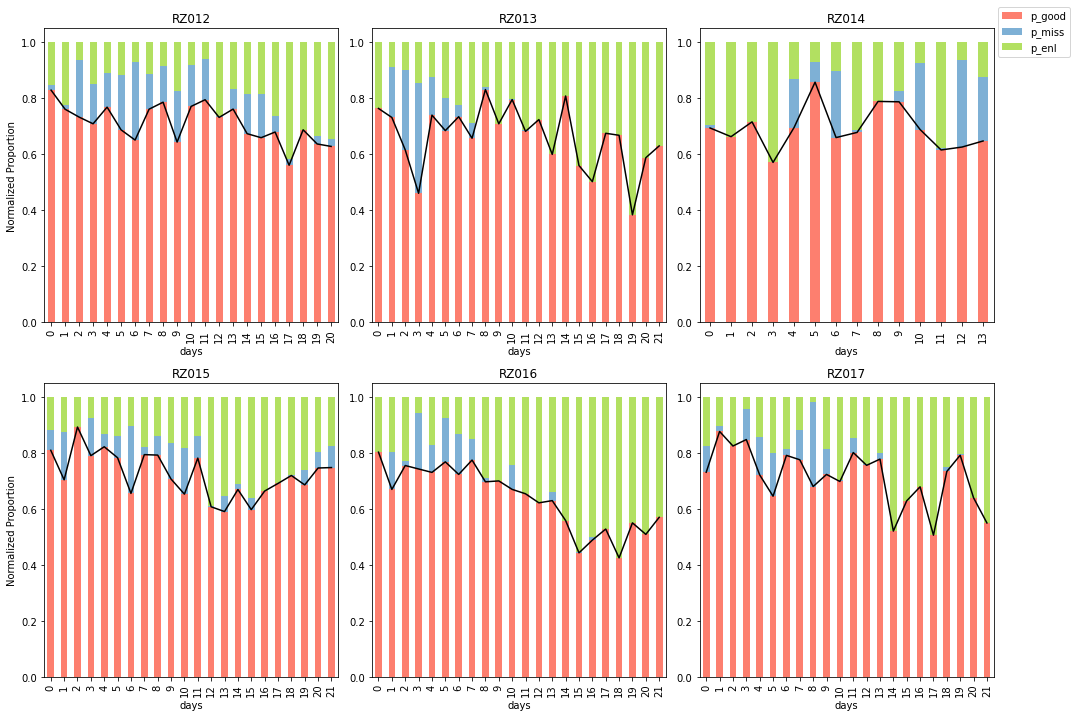

In [15]:
# ploting the proportion of good trials, miss trials, and enl trials per session
fig, axs = plt.subplots(2, 3, figsize=(14, 10))  # 2 rows, 3 columns

# Loop through the mouse list and plot data for each mouse in a subplot
for i, mouse in enumerate(mouse_list):
    session_mouse = trial_type_df.loc[trial_type_df.mouse == mouse]
    to_plot = session_mouse.loc[:, ['days', 'p_good', 'p_miss', 'p_enl']]
    ax = axs.flat[i]
    to_plot.plot.bar(x='days', stacked=True, color=colors[0:3], ax=ax, legend=None)
    ax.set_title(mouse)
    if i == 0 or i == 3:
        ax.set_ylabel('Normalized Proportion')
    ax.plot(to_plot.days, to_plot.p_good, color='k', linewidth=1.5)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.07, 1))

plt.tight_layout()
plt.savefig(f'{figure_folder}/engagement_plots.png', bbox_inches='tight')
plt.show()

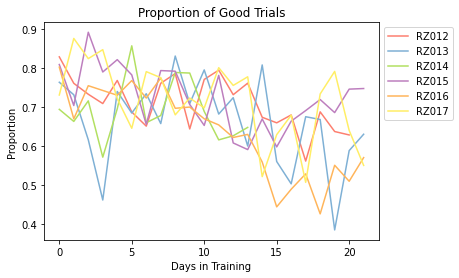

In [14]:
# plot the proportion of good trials
plot_each_mouse_per_line(data_df=trial_type_df, 
                         column_name='p_good', 
                         plot_name="%_good_trials", 
                         title='Proportion of Good Trials',
                         x_label='Days in Training', 
                         y_label='Proportion')

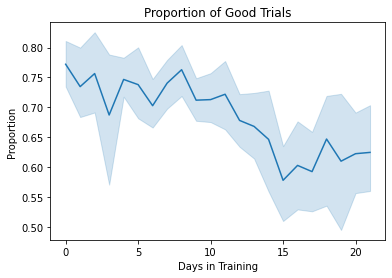

In [15]:
plot_overdays_colored_by_group(data_df=trial_type_df, 
                               column_name="p_good", 
                               plot_name='%_good_trials_by_group', 
                               title='Proportion of Good Trials', 
                               x_label='Days in Training', 
                               y_label='Proportion')

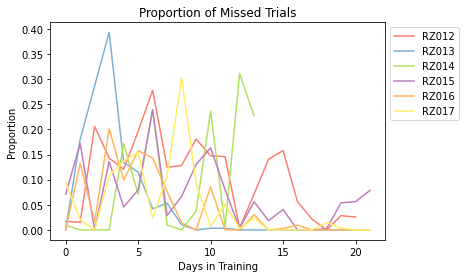

In [16]:
# plot the proportion of miss trials
plot_each_mouse_per_line(data_df=trial_type_df, 
                         column_name='p_miss', 
                         plot_name="%_miss_trials",
                         title='Proportion of Missed Trials', 
                         x_label='Days in Training', 
                         y_label='Proportion')

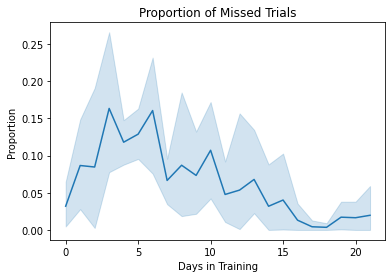

In [17]:
plot_overdays_colored_by_group(data_df=trial_type_df, 
                               column_name="p_miss", 
                               plot_name='%_miss_trials_by_group', 
                               title='Proportion of Missed Trials', 
                               x_label='Days in Training', 
                               y_label='Proportion')

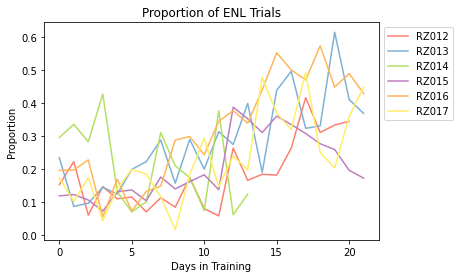

In [18]:
# plot the proportion of accident trials
plot_each_mouse_per_line(data_df=trial_type_df, 
                         column_name='p_enl', 
                         plot_name="%_enl_trials", 
                         title='Proportion of ENL Trials',
                         x_label='Days in Training', 
                         y_label='Proportion')

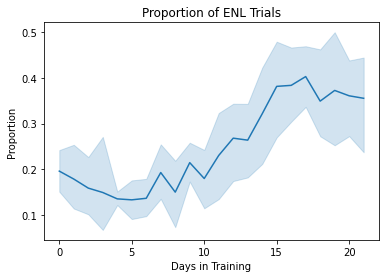

In [34]:
plot_overdays_colored_by_group(data_df=trial_type_df, 
                               column_name="p_enl", 
                               plot_name='%_enl_trials_by_group', 
                               title='Proportion of ENL Trials', 
                               x_label='Days in Training', 
                               y_label='Proportion')

## Plot mistakes per session

In [17]:
def get_blk_mistakes(all_trials):
    enl_list = []
    blk_type_list = ['l', 's']
    for blk_type in blk_type_list: 
        blk = all_trials.loc[all_trials['blk_type']==blk_type]
        enl_list.append(blk.enl_repeats.mean())
        enl_list.append(blk.enl_repeats.median())
        enl_list.append(blk.enl_repeats.std())
    return enl_list

In [18]:
def generate_mistake_df(training_session_log):
    mistake_df = training_session_log[['mouse', 'days', 'dir']]

    for dir_name in training_session_log.dir:
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        session_mistakes = helper.get_session_mistakes(all_trials)
        mistake_df.loc[mistake_df.dir == dir_name, 
                                ['num_enl_repeats_mean', 'num_enl_repeats_median', 
                                'num_enl_repeats_stdev']] = session_mistakes
        
        block_mistakes = get_blk_mistakes(all_trials)
        mistake_df.loc[mistake_df.dir == dir_name, 
                                    ['enl_l_mean', 'enl_l_median', 'enl_l_stdev',
                                    'enl_s_mean', 'enl_s_median','enl_s_stdev']] = block_mistakes
    
    return mistake_df

In [19]:
mistake_df = generate_mistake_df(training_session_log)

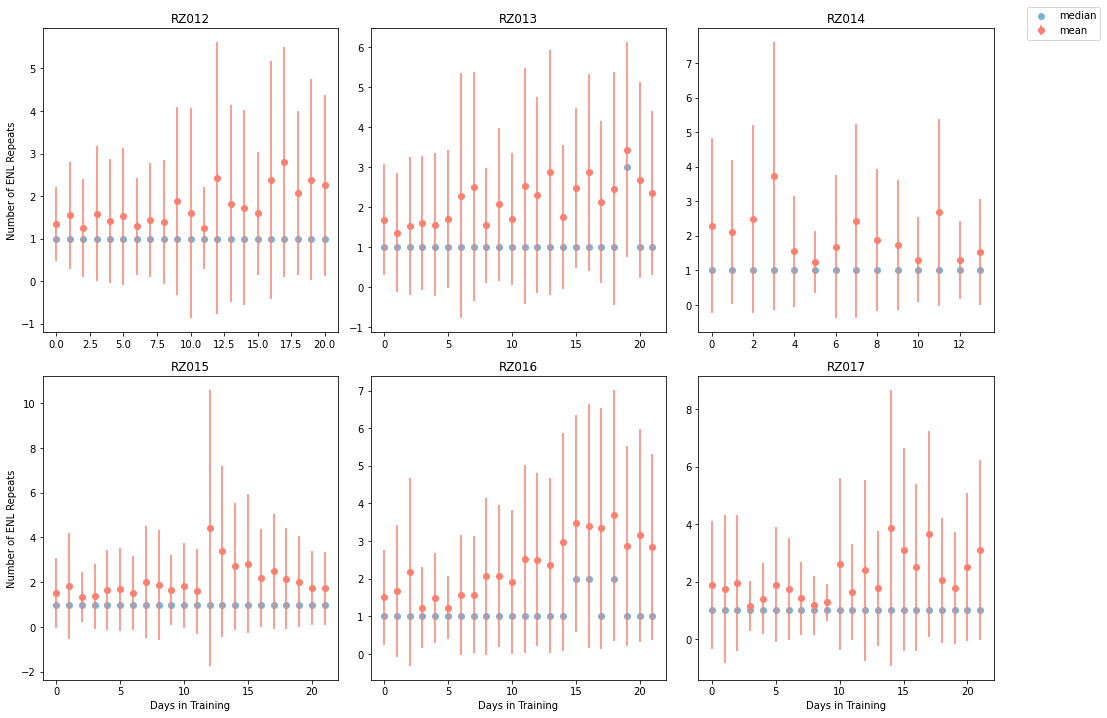

In [99]:
fig, axs = plt.subplots(2, 3, figsize=(14, 10))  # 2 rows, 3 columns

# Loop through the mouse list and plot data for each mouse in a subplot
for i, mouse in enumerate(mouse_list):
    session_mouse = mistake_df.loc[mistake_df.mouse == mouse]
    ax = axs.flat[i]
    ax.errorbar(session_mouse.days, session_mouse.num_enl_repeats_mean, session_mouse.num_enl_repeats_stdev, 
                linestyle='None', marker='o', color=colors[0], label='mean')
    ax.scatter(session_mouse.days, session_mouse.num_enl_repeats_median, color=colors[1], label='median')
    ax.set_title(mouse)
    if i > 2:
        ax.set_xlabel('Days in Training')
    if i == 0 or i == 3:
        ax.set_ylabel('Number of ENL Repeats')

# Extract the legend from the first subplot
handles, labels = axs[0, 0].get_legend_handles_labels()

# Set the figure legend outside the loop
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1))

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure with proper spacing around the subplots
plt.savefig(f'{figure_folder}/enl_repeats_plots.png', bbox_inches='tight', dpi=300)

# Show the plot (optional)
plt.show()

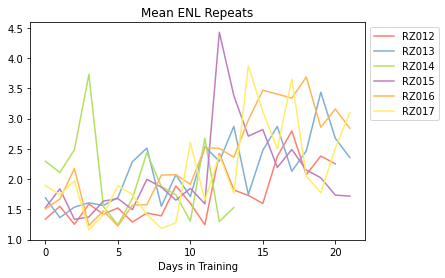

In [100]:
# plot the mean ENL repeats
plot_each_mouse_per_line(data_df=mistake_df, 
                         column_name='num_enl_repeats_mean', 
                         plot_name='enl_repeats_mean',
                         title='Mean ENL Repeats', 
                         x_label='Days in Training', 
                         y_label='')

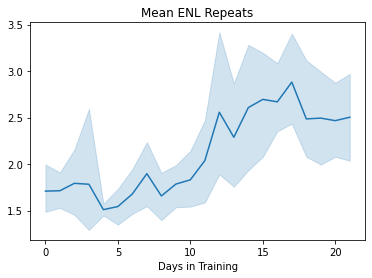

In [101]:
plot_overdays_colored_by_group(data_df=mistake_df, 
                               column_name="num_enl_repeats_mean", 
                               plot_name='ENL_repeats_mean_by_group', 
                               title='Mean ENL Repeats', 
                               x_label='Days in Training', 
                               y_label='')

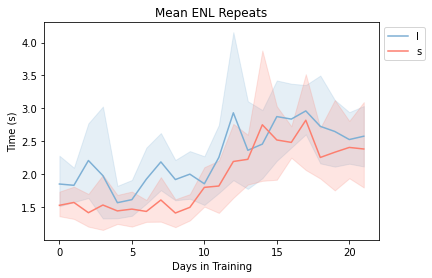

In [103]:
plot_overdays_l_vs_s(data_df = mistake_df, 
                     y1='enl_l_mean', 
                     y2='enl_s_mean', 
                     plot_name='enl_s_l', 
                     title='Mean ENL Repeats', 
                     y_label='Time (s)')

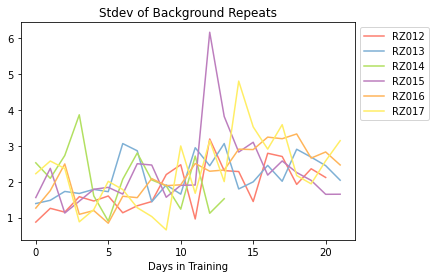

In [28]:
# plot the stdev ENL repeats
plot_each_mouse_per_line(data_df=mistake_df, 
                         column_name='num_enl_repeats_stdev', 
                         plot_name='enl_repeats_stdev',
                         title='Stdev of Background Repeats', 
                         x_label='Days in Training', 
                         y_label='')

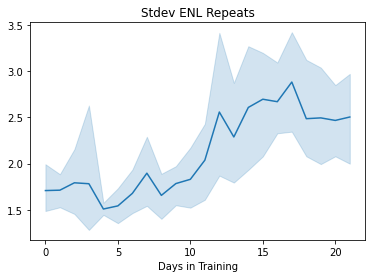

In [25]:
plot_overdays_colored_by_group(data_df=mistake_df, 
                               column_name="num_enl_repeats_mean", 
                               plot_name='bg_repeats_stdev_by_group', 
                               title='Stdev ENL Repeats', 
                               x_label='Days in Training', 
                               y_label='')

## Plot rewards per session

In [20]:
training_session_log['reward_rate'] = training_session_log.rewards/training_session_log.time

In [21]:
training_session_log['reward_per_trial'] = training_session_log.rewards/training_session_log.num_trials

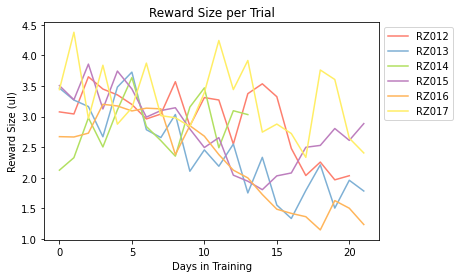

In [35]:
# plot the reward rize
plot_each_mouse_per_line(data_df=training_session_log, 
                         column_name='reward_per_trial', 
                         plot_name="reward_size_per_trial",
                         title='Reward Size per Trial', 
                         x_label='Days in Training', 
                         y_label='Reward Size (ul)')

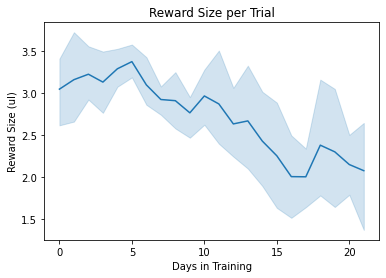

In [36]:
plot_overdays_colored_by_group(data_df=training_session_log, 
                               column_name="reward_per_trial", 
                               plot_name='reward_size_by_group', 
                               title='Reward Size per Trial', 
                               x_label='Days in Training', 
                               y_label='Reward Size (ul)')

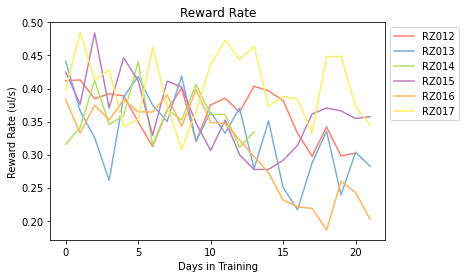

In [37]:
# plot the reward rate
plot_each_mouse_per_line(data_df=training_session_log, 
                         column_name='reward_rate', 
                         plot_name="reward_rate",
                         title='Reward Rate', 
                         x_label='Days in Training', 
                         y_label='Reward Rate (ul/s)')

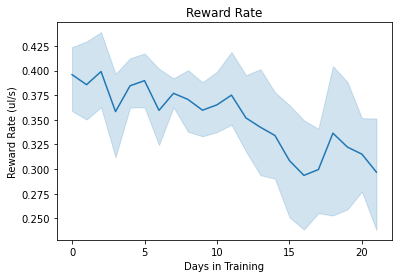

In [24]:
plot_overdays_colored_by_group(data_df=training_session_log, 
                               column_name="reward_rate", 
                               plot_name='reward_rate_by_group', 
                               title='Reward Rate', 
                               x_label='Days in Training', 
                               y_label='Reward Rate (ul/s)')

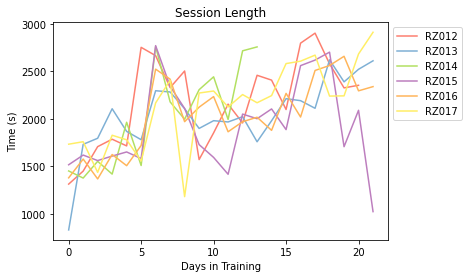

In [35]:
# plot the session length
plot_each_mouse_per_line(data_df=training_session_log, 
                         column_name='time', 
                         plot_name="session_length", 
                         title='Session Length',
                         x_label='Days in Training', 
                         y_label='Time (s)')

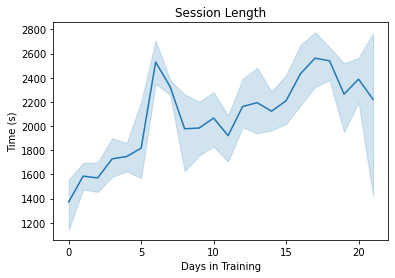

In [36]:
plot_overdays_colored_by_group(data_df=training_session_log, 
                               column_name="time", 
                               plot_name='session_length_by_group', 
                               title='Session Length', 
                               x_label='Days in Training', 
                               y_label='Time (s)')

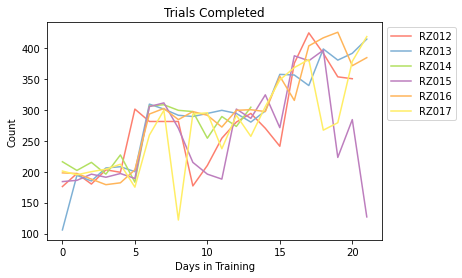

In [37]:
# plot the number of trials completed
plot_each_mouse_per_line(data_df=training_session_log, 
                         column_name='num_trials', 
                         plot_name="num_trials", 
                         title='Trials Completed',
                         x_label='Days in Training', 
                         y_label='Count')

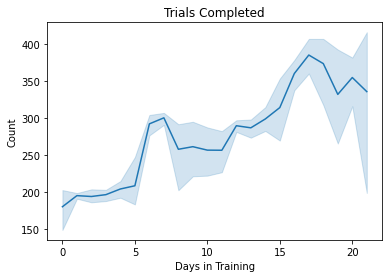

In [38]:
plot_overdays_colored_by_group(data_df=training_session_log, 
                               column_name="num_trials", 
                               plot_name='num_trials_by_group', 
                               title='Trials Completed', 
                               x_label='Days in Training', 
                               y_label='Count')

## Plot time wait behavior

In [8]:
def get_session_tw(all_trials):
    tw_mean = all_trials.time_waited.mean()
    tw_med = all_trials.time_waited.median()
    tw_std = all_trials.time_waited.std()
    return [tw_mean, tw_med, tw_std]

In [9]:
def get_block_tw(all_trials):
    tw_list = []
    blk_type_list = ['l', 's']
    for blk_type in blk_type_list: 
        blk = all_trials.loc[all_trials['blk_type']==blk_type]
        tw_list.append(blk.time_waited.mean())
        tw_list.append(blk.time_waited.median())
        tw_list.append(blk.time_waited.std())
    return tw_list

In [10]:
def select_good_trials(all_trials):
    good_trials = all_trials.loc[(all_trials['miss_trial'] == False) & (all_trials['enl_repeats'] == 1)]
    return good_trials

In [11]:
def generate_wait_df(training_session_log):
    wait_df = training_session_log[['mouse', 'days', 'dir']].copy()

    for dir_name in training_session_log.dir:
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        # time waited for all trials
        session_tw = get_session_tw(all_trials)
        wait_df.loc[wait_df.dir == dir_name, 
                                ['tw_mean', 'tw_median', 'tw_stdev']] = session_tw
        # time waited for long and short blocks
        block_tw = get_block_tw(all_trials)
        wait_df.loc[wait_df.dir == dir_name, 
                                ['tw_l_mean', 'tw_l_median', 'tw_l_stdev',
                                'tw_s_mean', 'tw_s_median','tw_s_stdev']] = block_tw

        good_trials = select_good_trials(all_trials)
         # time waited for good trials
        session_tw_g = get_session_tw(good_trials)
        wait_df.loc[wait_df.dir == dir_name, 
                                ['tw_mean_g', 'tw_median_g', 'tw_stdev_g']] = session_tw_g
        block_tw_g = get_block_tw(good_trials)
        wait_df.loc[wait_df.dir == dir_name, 
                                ['tw_l_mean_g', 'tw_l_median_g', 'tw_l_stdev_g',
                                'tw_s_mean_g', 'tw_s_median_g','tw_s_stdev_g']] = block_tw_g

    wait_df['tw_diff'] = wait_df['tw_l_mean'] - wait_df['tw_s_mean']
    wait_df['tw_diff_g'] = wait_df['tw_l_mean_g'] - wait_df['tw_s_mean_g']
    return wait_df

In [14]:
def save_log(log_df, data_folder, filename):
    path = os.path.join(data_folder, filename)
    log_df.to_csv(path, index=False)

In [15]:
wait_df = generate_wait_df(training_session_log)
save_log(wait_df, data_folder, 'wait.csv')

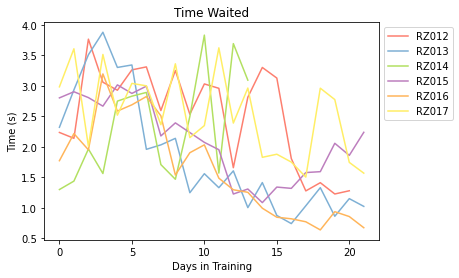

In [48]:
# plot the time waited over days. 
plot_each_mouse_per_line(data_df=wait_df, 
                         column_name='tw_mean', 
                         plot_name="tw_mean", 
                         title='Time Waited',
                         x_label='Days in Training', 
                         y_label='Time (s)')

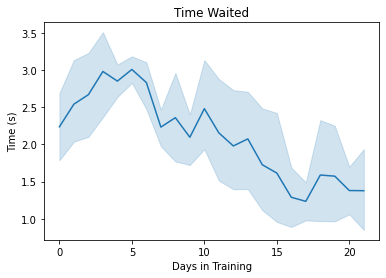

In [49]:
plot_overdays_colored_by_group(data_df=wait_df, 
                               column_name="tw_mean", 
                               plot_name='tw_mean_by_group', 
                               title='Time Waited', 
                               x_label='Days in Training', 
                               y_label='Time (s)')

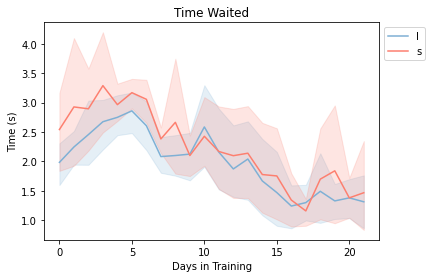

In [82]:
plot_overdays_l_vs_s(data_df = wait_df, 
                     y1='tw_l_mean', 
                     y2='tw_s_mean', 
                     plot_name='tw_s_l', 
                     title='Time Waited', 
                     y_label='Time (s)')

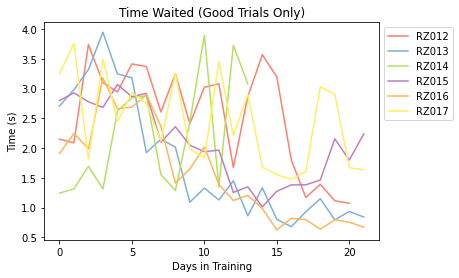

In [105]:
# plot the time waited over days good trials only. 
plot_each_mouse_per_line(data_df=wait_df, 
                         column_name='tw_mean_g', 
                         plot_name="tw_mean_g", 
                         title='Time Waited (Good Trials Only)',
                         x_label='Days in Training', 
                         y_label='Time (s)')

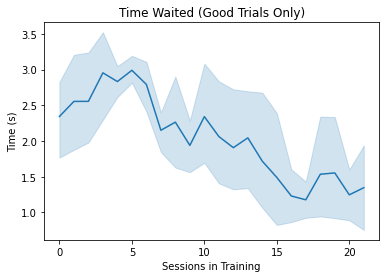

In [106]:
plot_overdays_colored_by_group(data_df=wait_df, 
                               column_name="tw_mean_g", 
                               plot_name='tw_mean_g_by_group', 
                               title='Time Waited (Good Trials Only)', 
                               x_label='Sessions in Training', 
                               y_label='Time (s)')

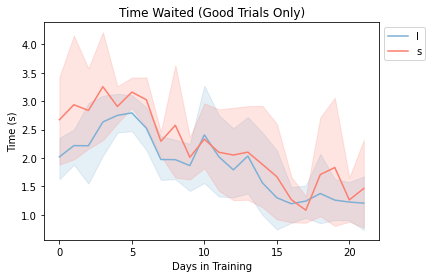

In [108]:
plot_overdays_l_vs_s(data_df = wait_df, 
                     y1='tw_l_mean_g', 
                     y2='tw_s_mean_g', 
                     plot_name='tw_s_l_g', 
                     title='Time Waited (Good Trials Only)', 
                     y_label='Time (s)')

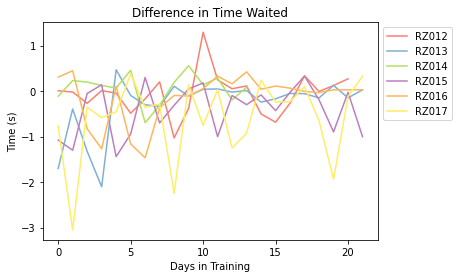

In [109]:
# plot the difference in time waited bewteen long and short blocks over days. 
plot_each_mouse_per_line(data_df=wait_df, 
                         column_name='tw_diff', 
                         plot_name="tw_diff", 
                         title='Difference in Time Waited',
                         x_label='Days in Training', 
                         y_label='Time (s)')

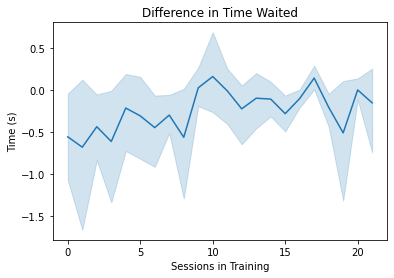

In [110]:
plot_overdays_colored_by_group(data_df=wait_df, 
                               column_name="tw_diff", 
                               plot_name='tw_diff_by_group', 
                               title='Difference in Time Waited', 
                               x_label='Sessions in Training', 
                               y_label='Time (s)')

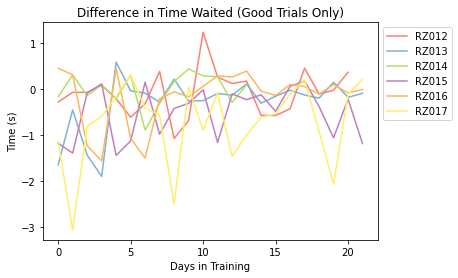

In [111]:
# plot the difference in time waited bewteen long and short blocks over days. good trials only
plot_each_mouse_per_line(data_df=wait_df, 
                         column_name='tw_diff_g', 
                         plot_name="tw_diff_g", 
                         title='Difference in Time Waited (Good Trials Only)',
                         x_label='Days in Training', 
                         y_label='Time (s)')

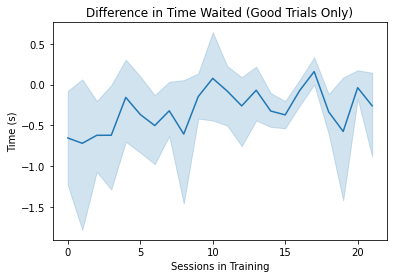

In [112]:
plot_overdays_colored_by_group(data_df=wait_df, 
                               column_name="tw_diff_g", 
                               plot_name='tw_diff_g_by_group', 
                               title='Difference in Time Waited (Good Trials Only)', 
                               x_label='Sessions in Training', 
                               y_label='Time (s)')

In [113]:
def generate_linear_fit_df(training_session_log):
    linear_fit_df = training_session_log[['mouse', 'days', 'dir']].copy()
    for dir_name in training_session_log.dir:
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        all_trials = all_trials[all_trials['time_waited'].notna()]
        fit_data = utils.linear_fit(all_trials, 'bg_length', 'time_waited')
        linear_fit_df.loc[linear_fit_df.dir == dir_name, 
                                ['slope', 'intercept', 'rsquared']] = fit_data
    return linear_fit_df

In [114]:
linear_fit_df = generate_linear_fit_df(training_session_log)

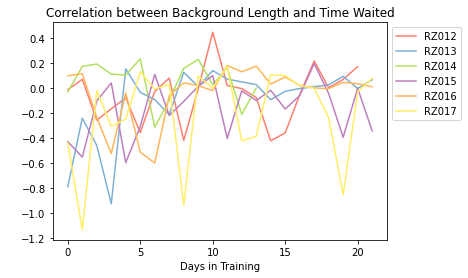

In [115]:
# plot the difference in time waited bewteen long and short blocks over days. good trials only
plot_each_mouse_per_line(data_df=linear_fit_df, 
                         column_name='slope', 
                         plot_name="tb_tw_correlation", 
                         title='Correlation between Background Length and Time Waited',
                         x_label='Days in Training', 
                         y_label=' ')

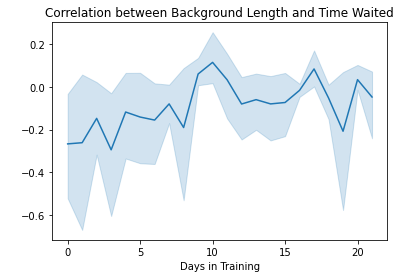

In [116]:
plot_overdays_colored_by_group(data_df=linear_fit_df, 
                               column_name="slope", 
                               plot_name='tb_tw_correlation_by_group', 
                               title='Correlation between Background Length and Time Waited', 
                               x_label='Days in Training', 
                               y_label=' ')

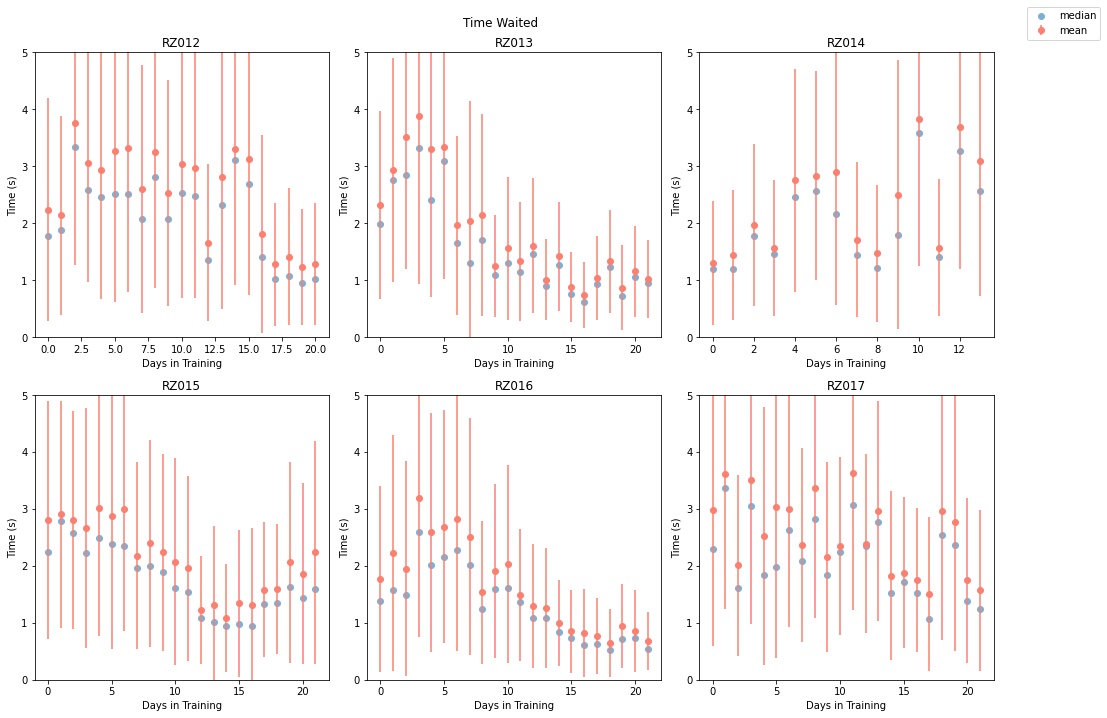

In [31]:
fig, axs = plt.subplots(2, 3, figsize=(14, 10))  # 2 rows, 3 columns

# Loop through the mouse list and plot data for each mouse in a subplot
for i, mouse in enumerate(mouse_list):
    session_mouse = wait_df.loc[wait_df.mouse == mouse]
    ax = axs.flat[i]
    ax.errorbar(session_mouse.days, session_mouse.tw_mean, session_mouse.tw_stdev, 
                linestyle='None', marker='o', color=colors[0], label='mean')
    ax.scatter(session_mouse.days, session_mouse.tw_median, color=colors[1], 
               label='median')
    ax.set_title(mouse)
    ax.set_xlabel('Days in Training')
    ax.set_ylabel('Time (s)')
    ax.set_ylim(0, 5)

handles, labels = axs[0, 0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1))
fig.suptitle('Time Waited')

plt.tight_layout()

plt.savefig(f'{figure_folder}/tw_plots.png', bbox_inches='tight', dpi=300)

plt.show()

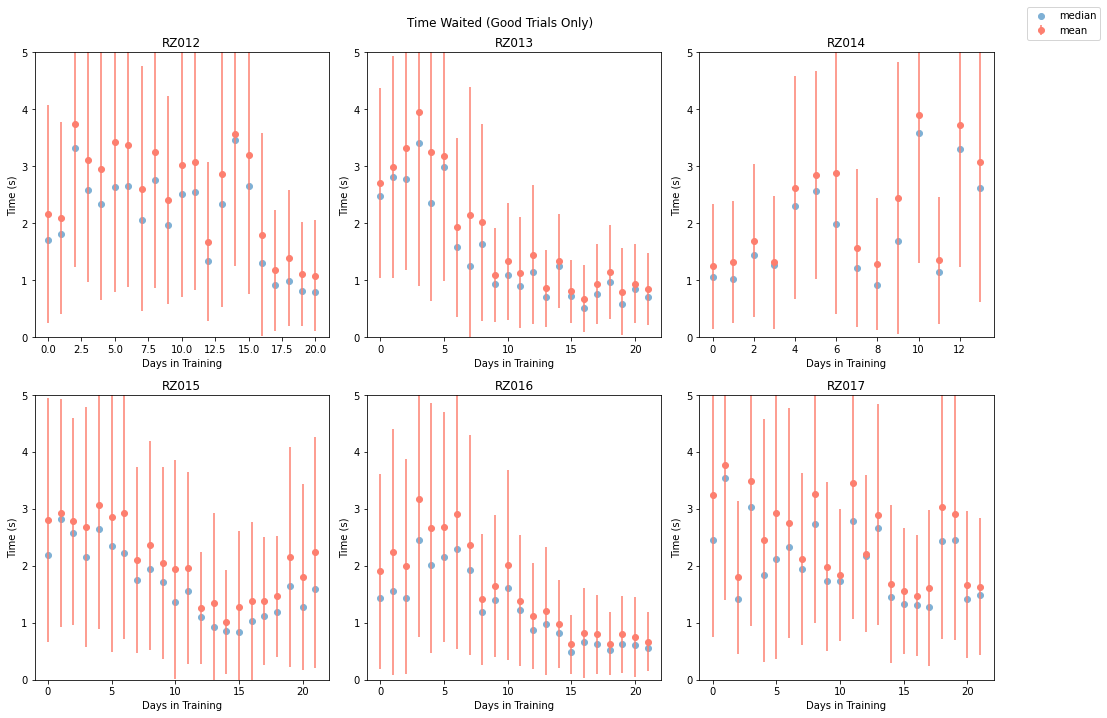

In [32]:
# Create a figure with six subplots
fig, axs = plt.subplots(2, 3, figsize=(14, 10))  # 2 rows, 3 columns

# Loop through the mouse list and plot data for each mouse in a subplot
for i, mouse in enumerate(mouse_list):
    session_mouse = wait_df.loc[wait_df.mouse == mouse]
    ax = axs.flat[i]
    ax.errorbar(session_mouse.days, session_mouse.tw_mean_g, session_mouse.tw_stdev_g, 
                linestyle='None', marker='o', color=colors[0], label='mean')
    ax.scatter(session_mouse.days, session_mouse.tw_median_g, color=colors[1], 
               label='median')
    ax.set_title(mouse)
    ax.set_xlabel('Days in Training')
    ax.set_ylabel('Time (s)')
    ax.set_ylim(0, 5)

# Extract the legend from the first subplot
handles, labels = axs[0, 0].get_legend_handles_labels()

# Set the figure legend outside the loop
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1))
fig.suptitle('Time Waited (Good Trials Only)')

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure with proper spacing around the subplots
plt.savefig(f'{figure_folder}/tw_good_plots.png', bbox_inches='tight', dpi=300)

# Show the plot (optional)
plt.show()

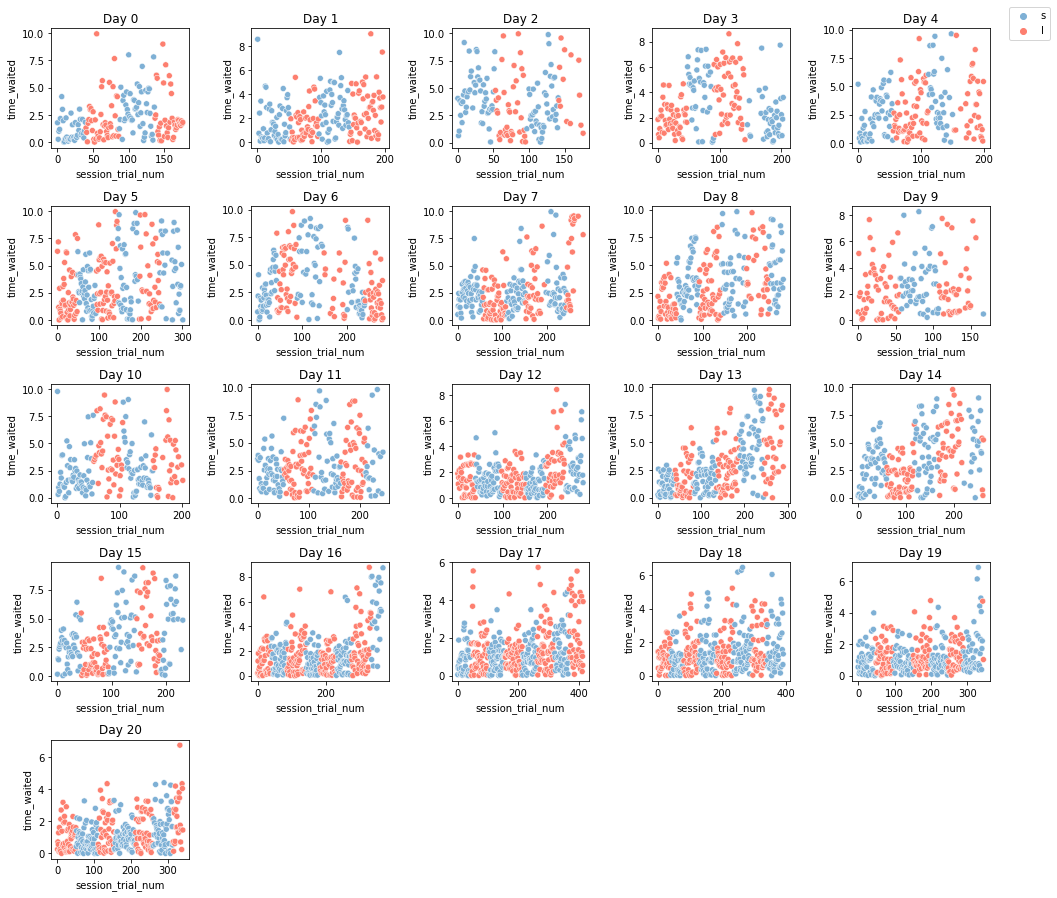

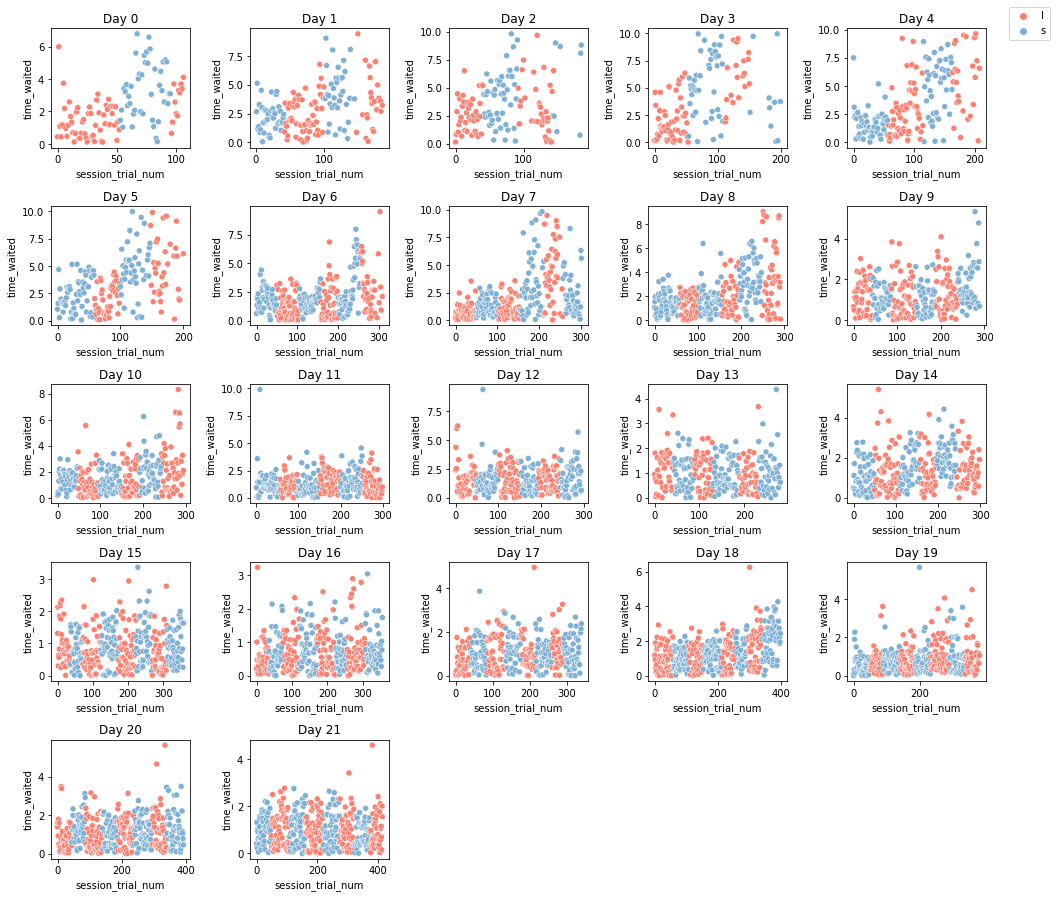

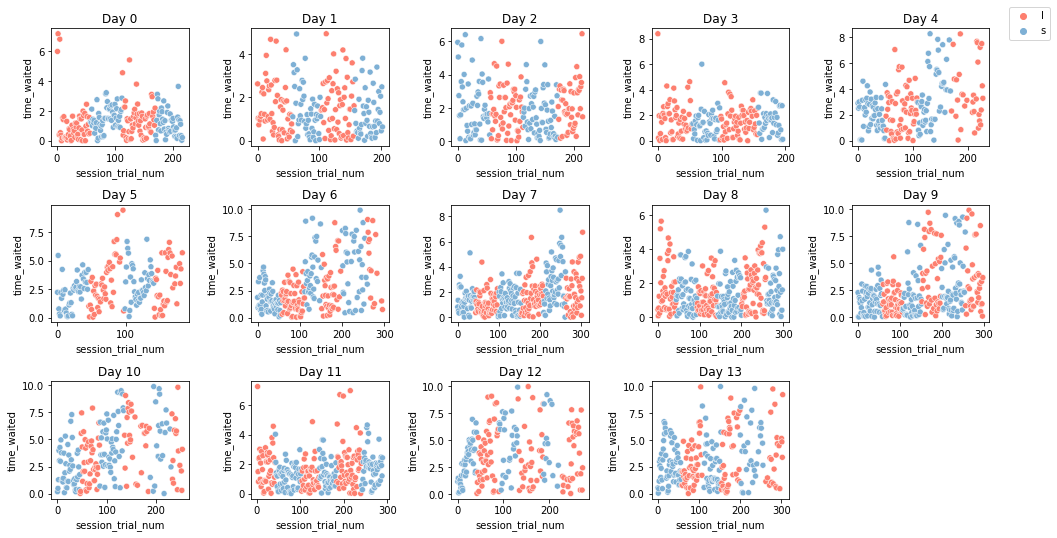

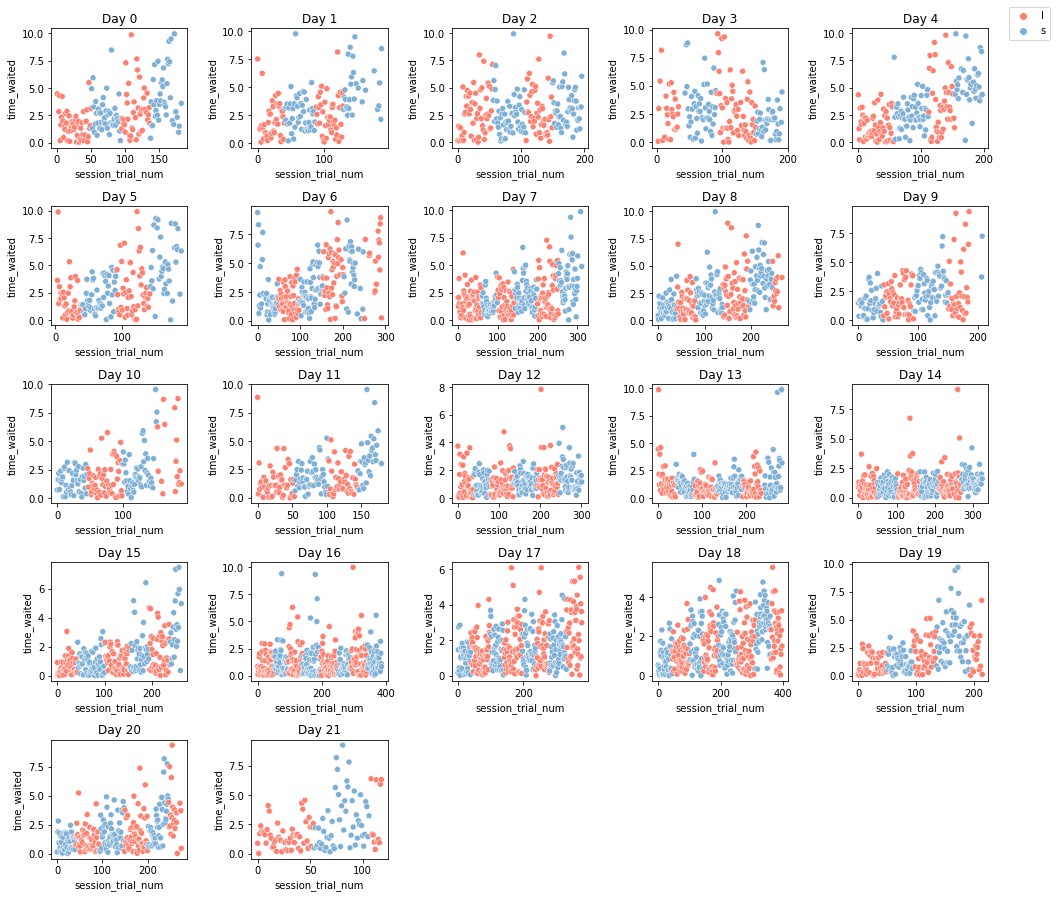

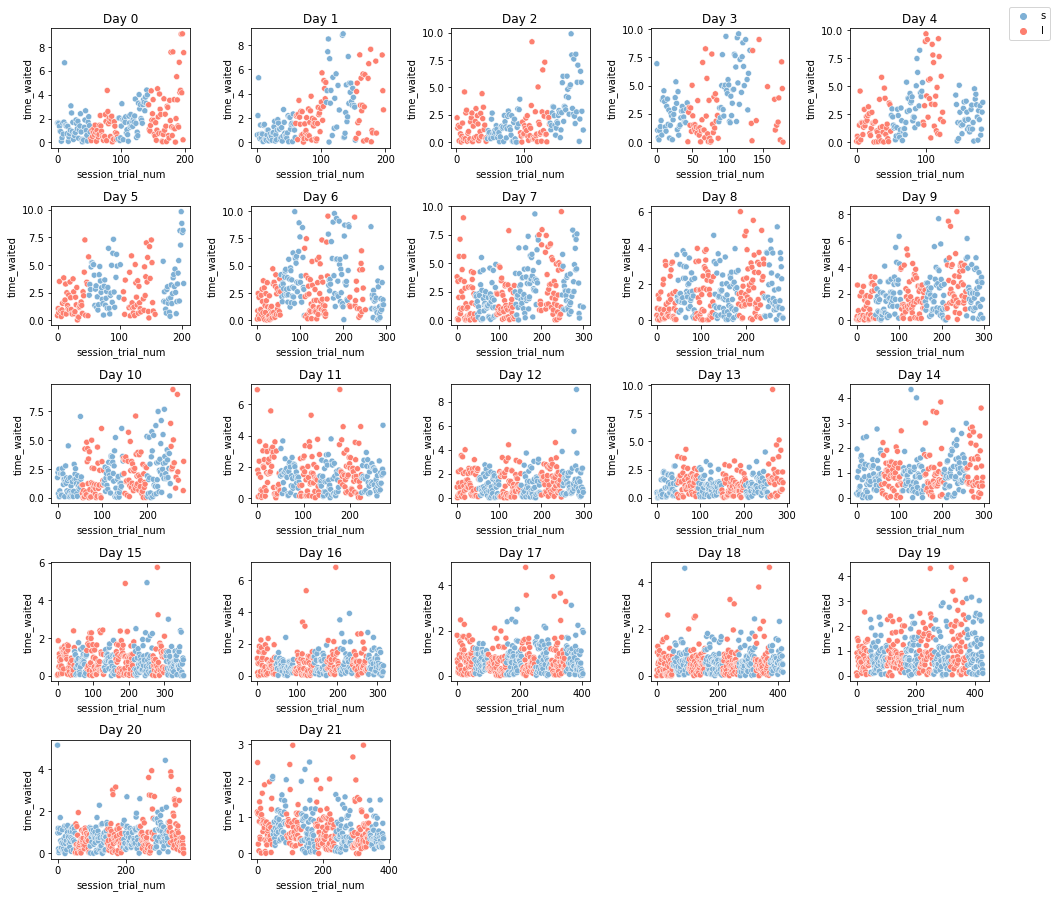

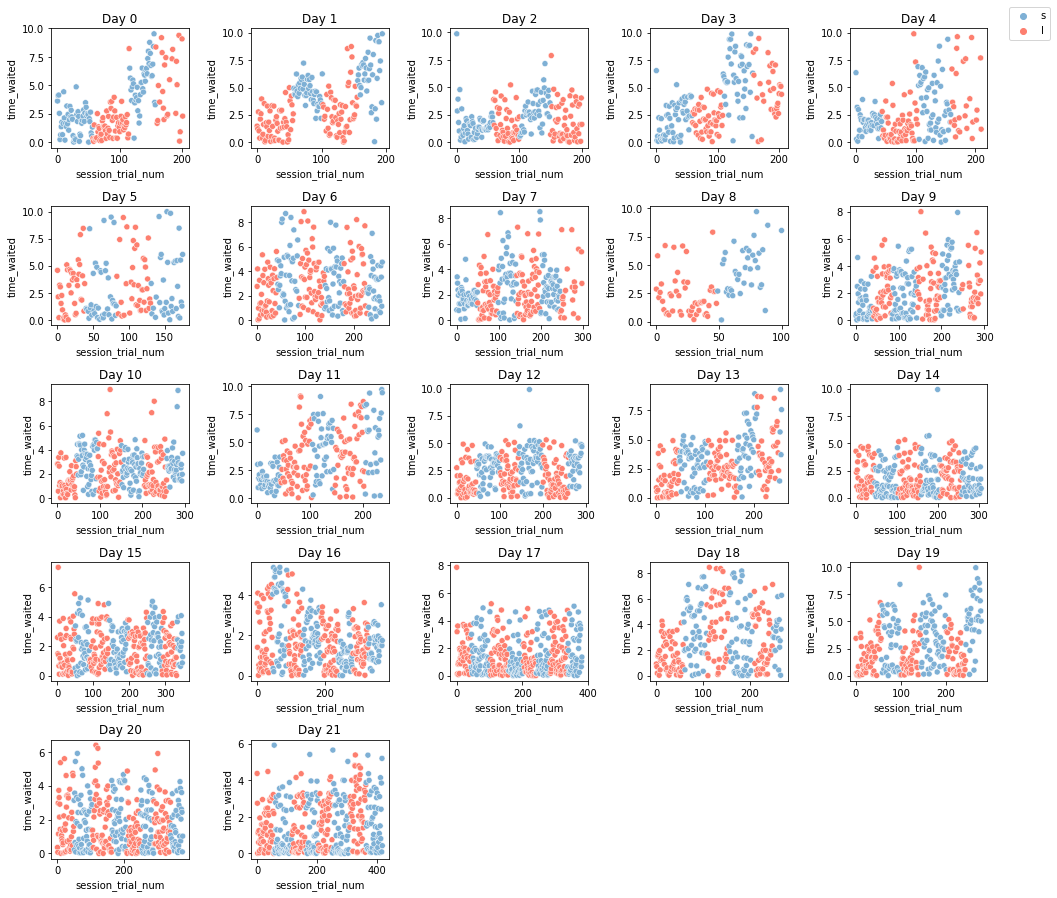

In [121]:
for mouse in mouse_list:
    session_mouse = training_session_log.loc[training_session_log.mouse == mouse]
    days_trained = len(session_mouse)

    # Calculate the number of rows and columns for the subplot grid
    num_rows = (days_trained - 1) // 5 + 1
    num_cols = min(days_trained, 5)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(14, 2.5 * num_rows))

    for i, (dir_name, day) in enumerate(zip(session_mouse.dir, session_mouse.days)):
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        row_idx = i // num_cols
        col_idx = i % num_cols
        ax = axs[row_idx, col_idx]
        
        custom_palette = {'l': colors[0], 's': colors[1]}
        
        sns.scatterplot(x="session_trial_num",
                        y="time_waited",
                        hue="blk_type",
                        data=all_trials,
                        palette=custom_palette,
                        ax=axs.flat[i])
        ax.set_title(f'Day {day}')

    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1))
    
    # Remove any unused subplots
    if i + 1 < num_rows * num_cols:
        for j in range(i + 1, num_rows * num_cols):
            axs.flat[j].axis('off')
    
    for i in range(days_trained):
        ax = axs.flat[i]
        ax.get_legend().remove()

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Save the figure with proper spacing around the subplots
    plt.savefig(f'{figure_folder}/trial_num_vs_tw_{mouse}.png', bbox_inches='tight', dpi=300)

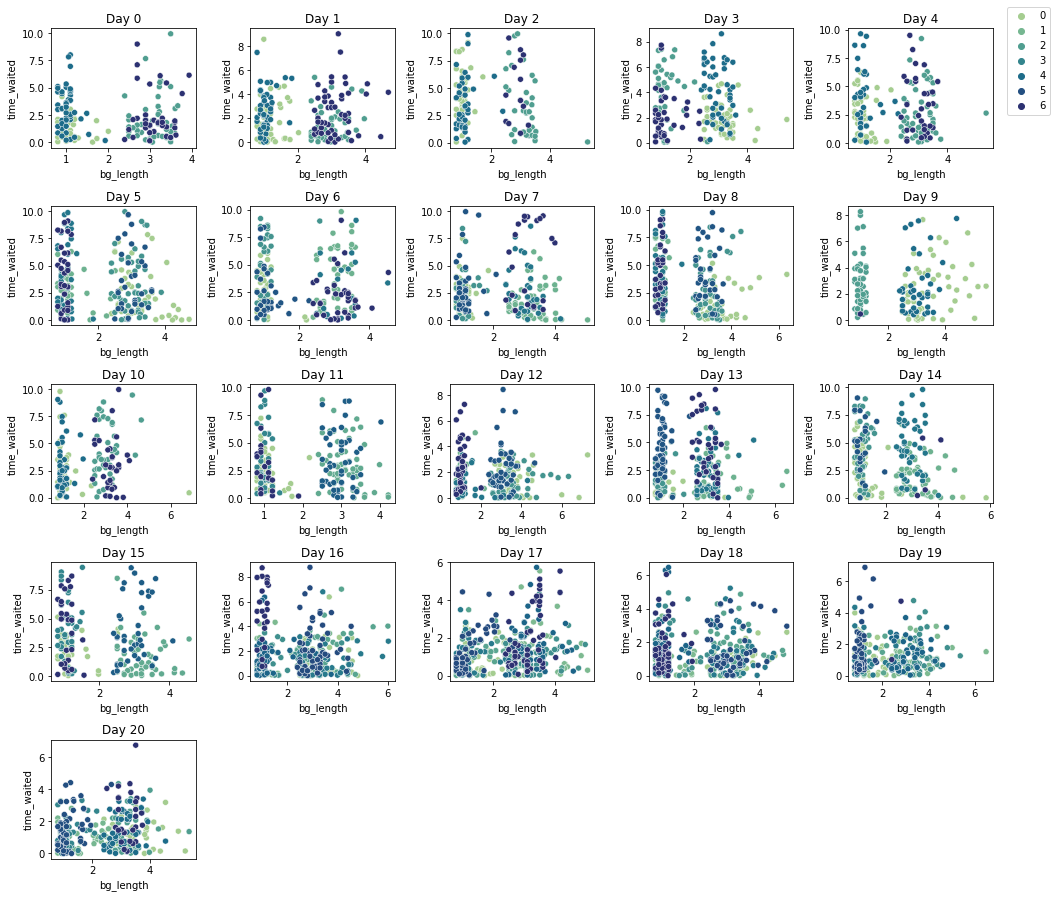

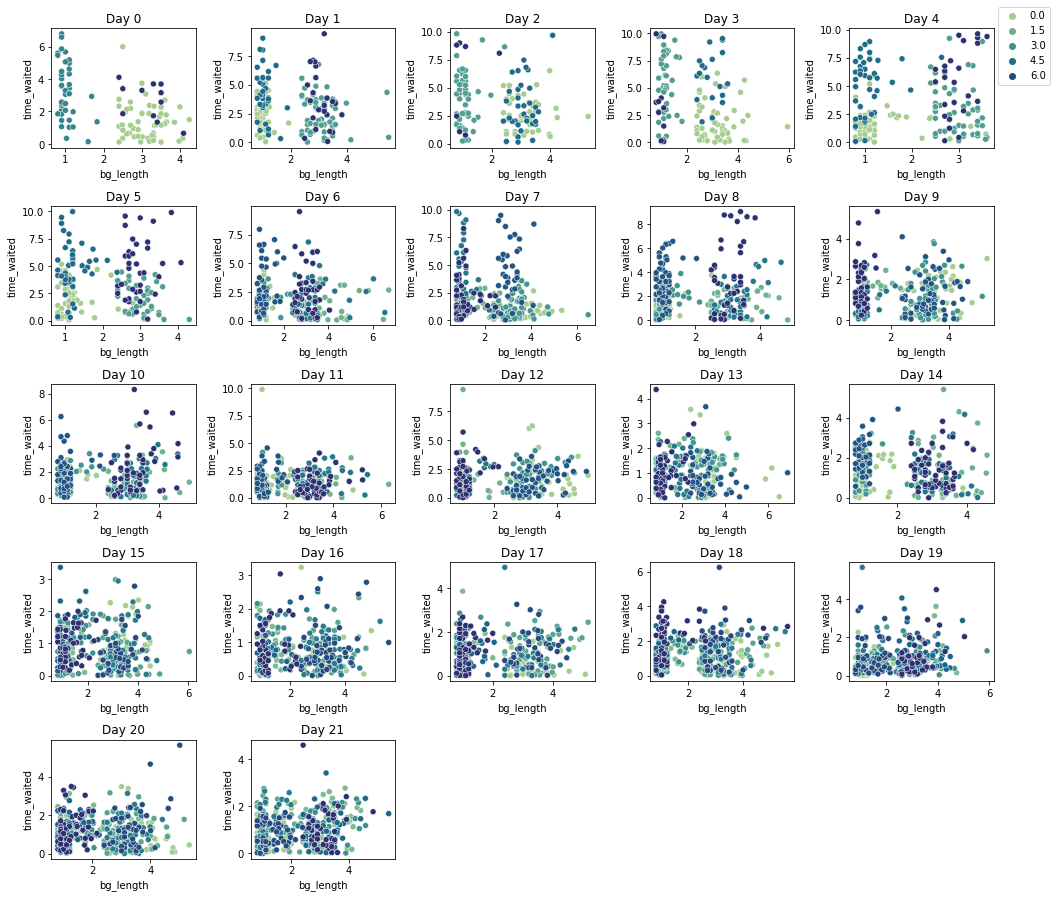

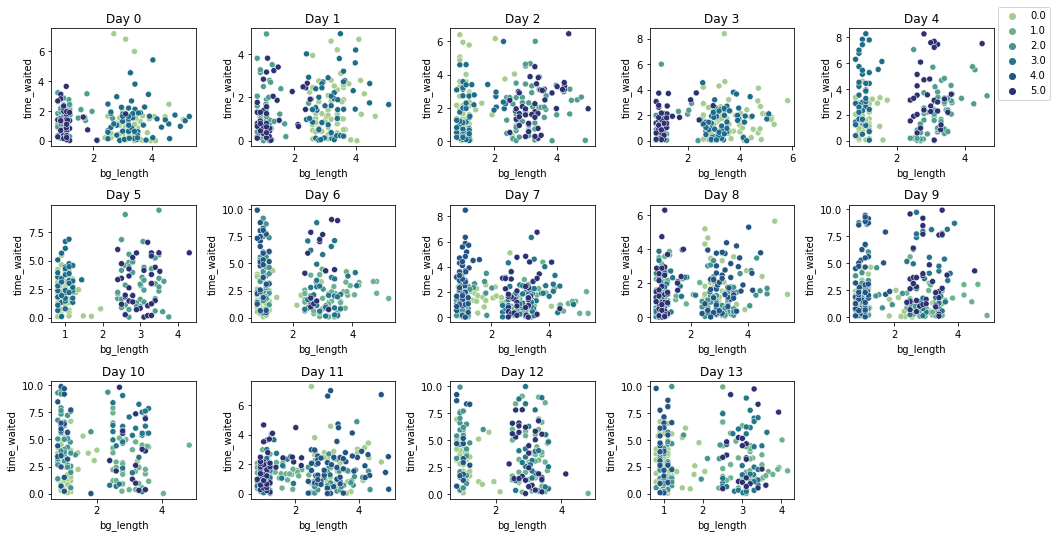

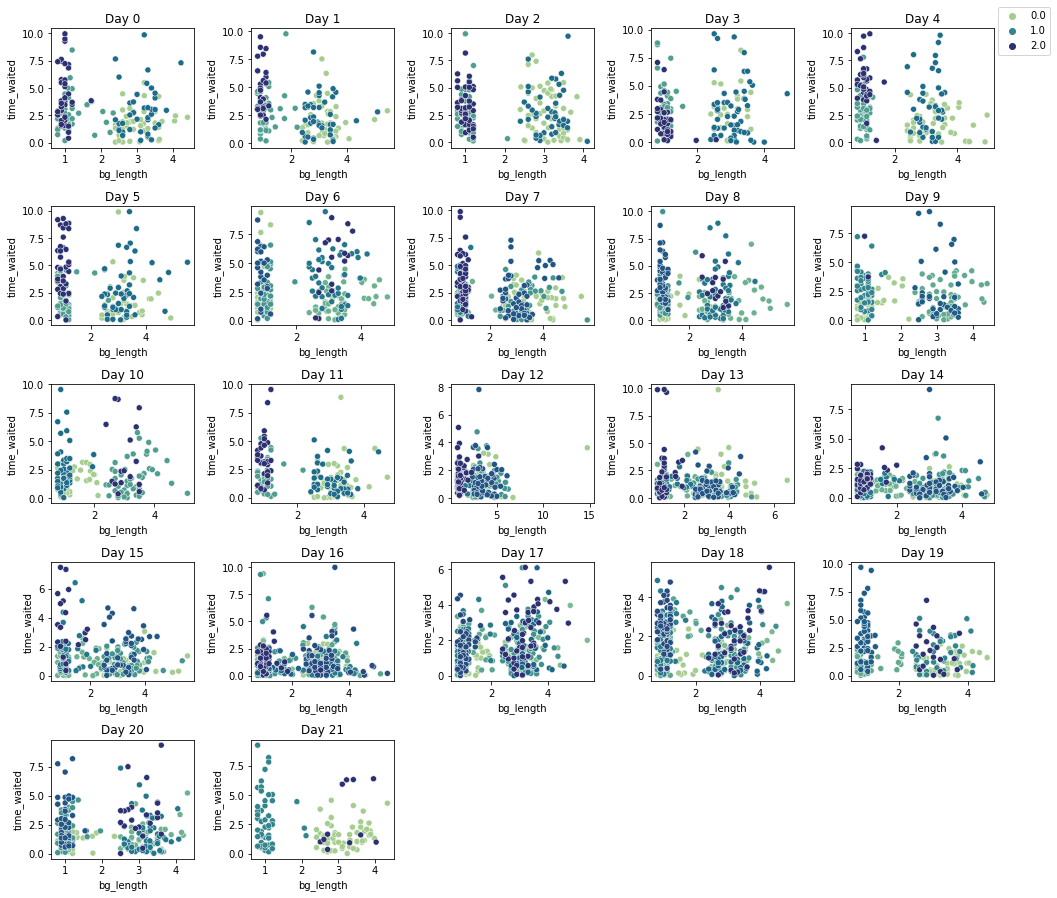

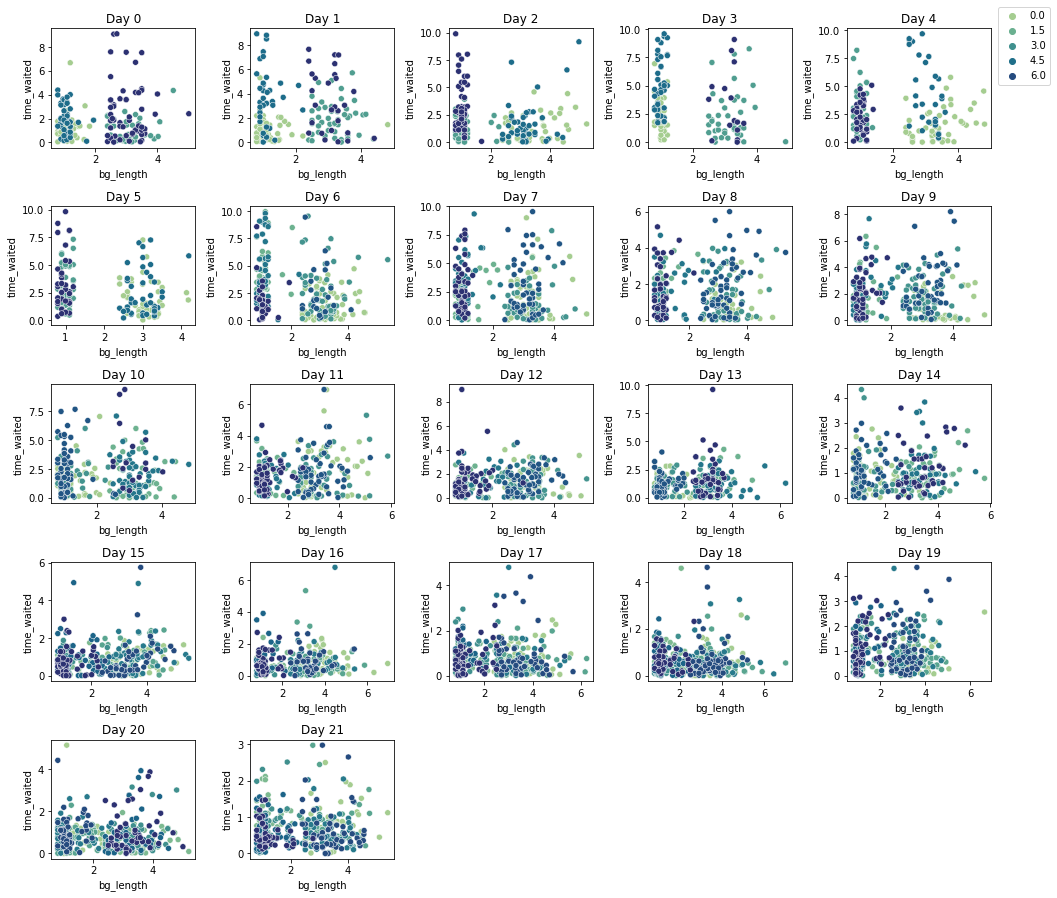

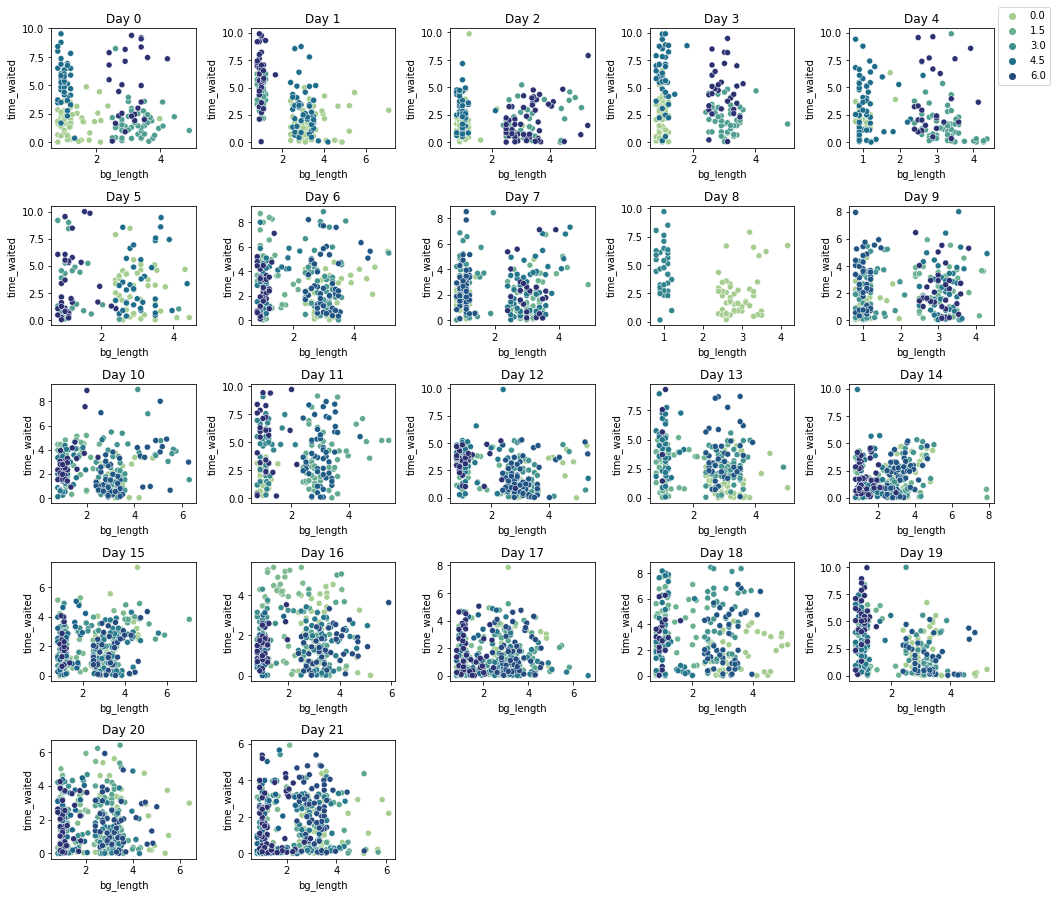

In [122]:
for mouse in mouse_list:
    session_mouse = training_session_log.loc[training_session_log.mouse == mouse]
    days_trained = len(session_mouse)

    # Calculate the number of rows and columns for the subplot grid
    num_rows = (days_trained - 1) // 5 + 1
    num_cols = min(days_trained, 5)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(14, 2.5 * num_rows))

    for i, (dir_name, day) in enumerate(zip(session_mouse.dir, session_mouse.days)):
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        row_idx = i // num_cols
        col_idx = i % num_cols
        ax = axs[row_idx, col_idx]
      
        sns.scatterplot(x="bg_length",
                        y="time_waited",
                        hue="block_num",
                        data=all_trials,
                        palette="crest",
                        ax=axs.flat[i])
        ax.set_title(f'Day {day}')
        handles, labels = ax.get_legend_handles_labels()
    
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1))
    
    # Remove any unused subplots
    if i + 1 < num_rows * num_cols:
        for j in range(i + 1, num_rows * num_cols):
            axs.flat[j].axis('off')
    
    for i in range(days_trained):
        ax = axs.flat[i]
        ax.get_legend().remove()

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Save the figure with proper spacing around the subplots
    plt.savefig(f'{figure_folder}/bg_vs_tw_blk_{mouse}.png', bbox_inches='tight', dpi=300)

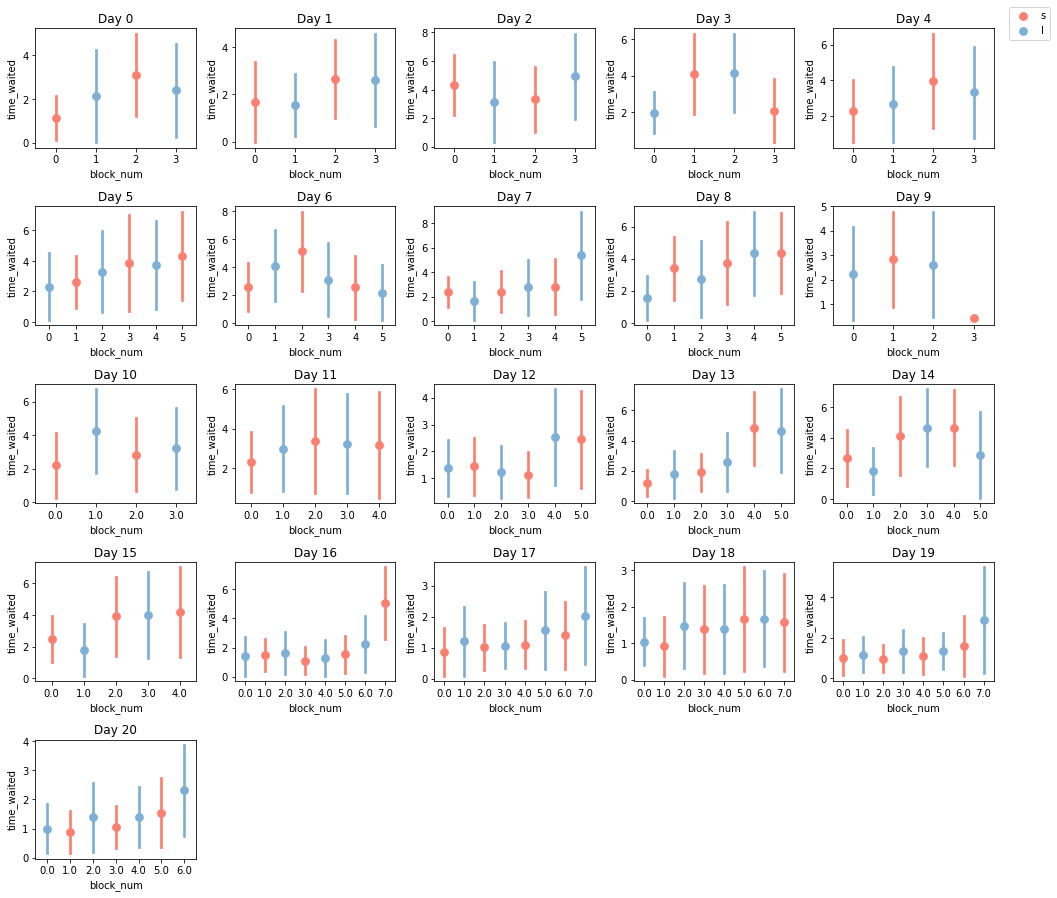

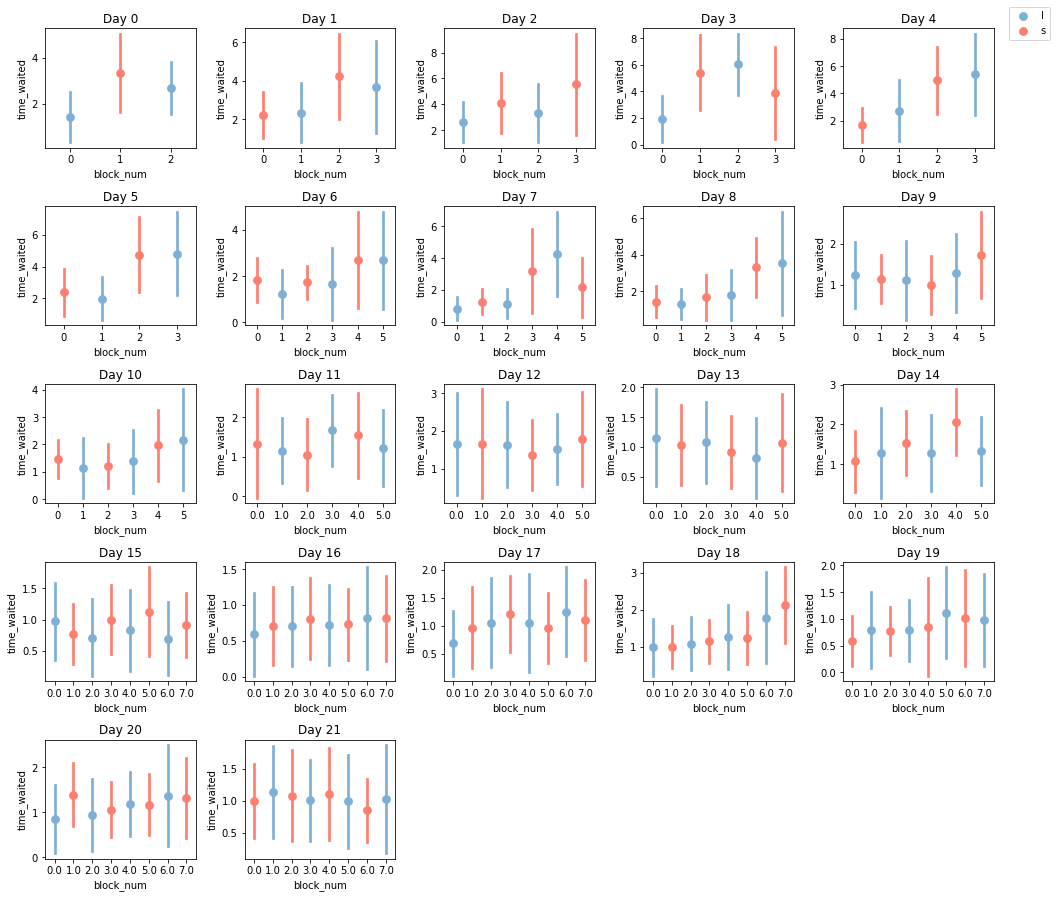

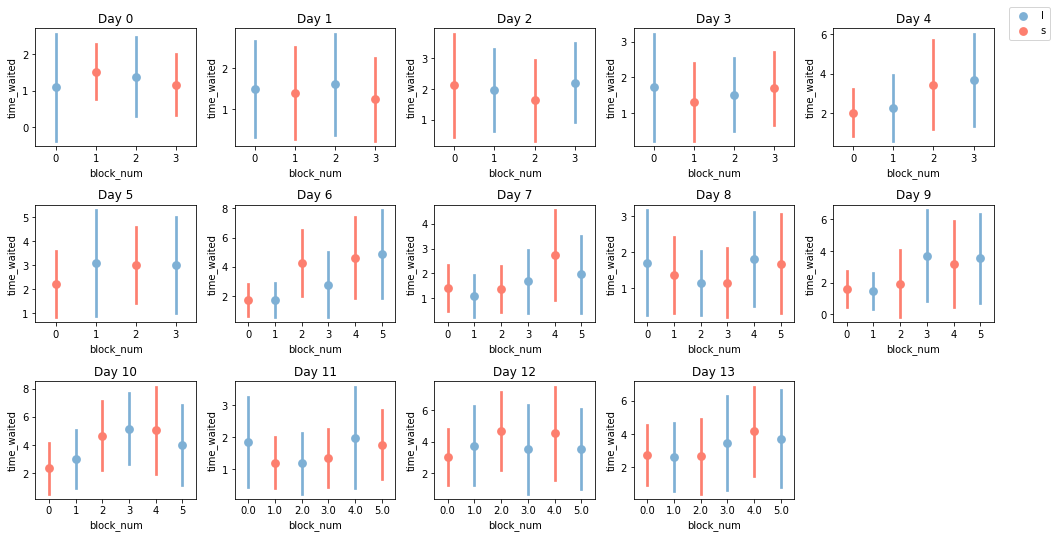

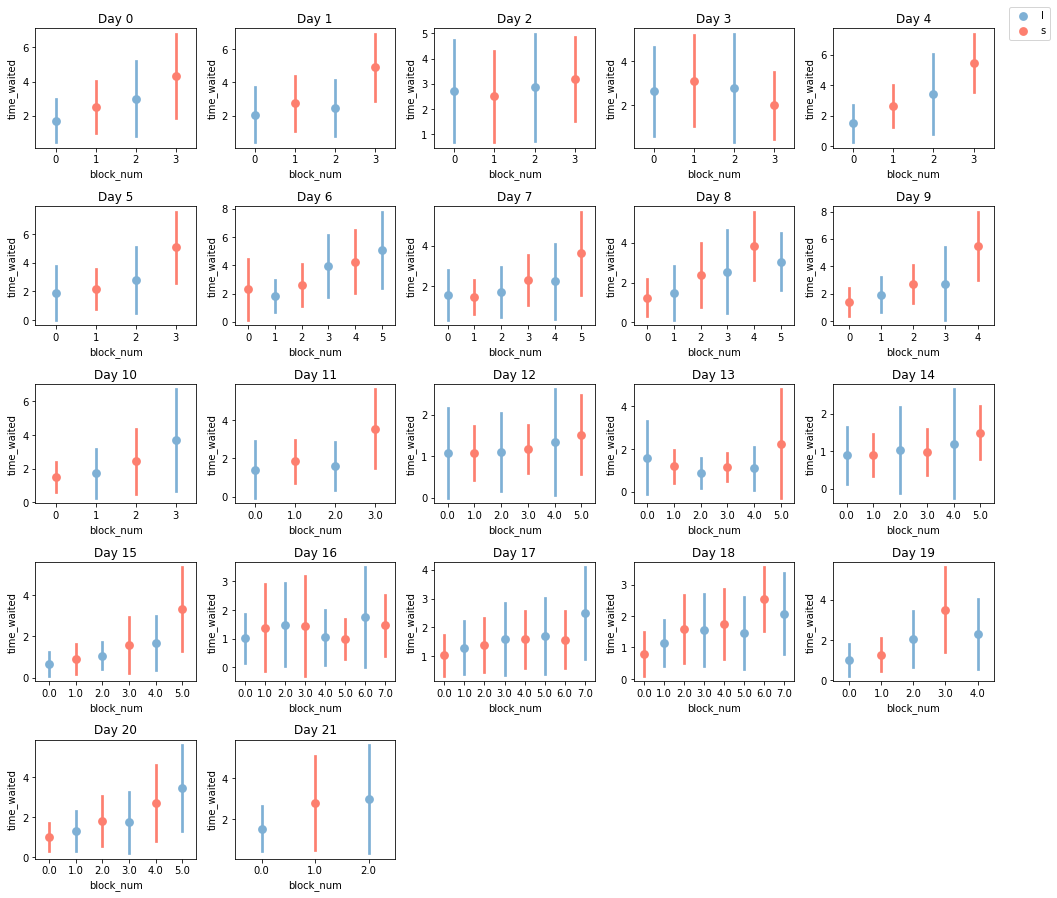

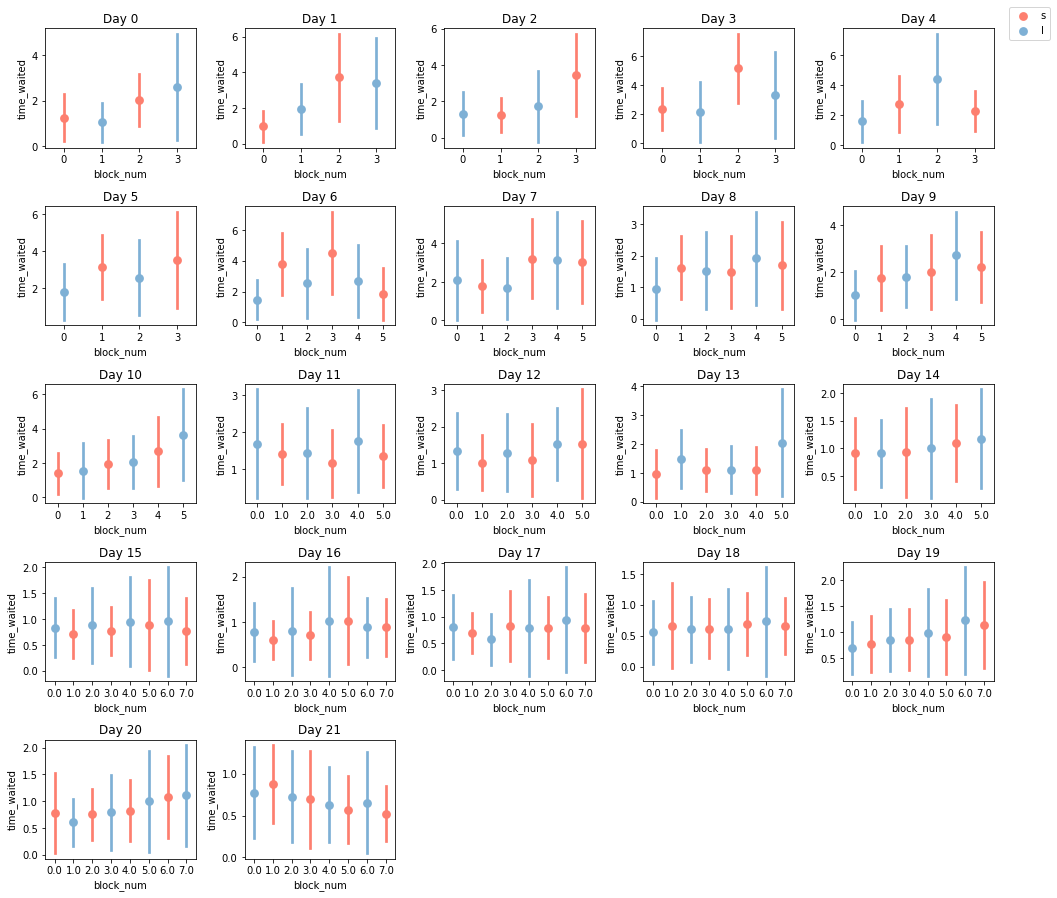

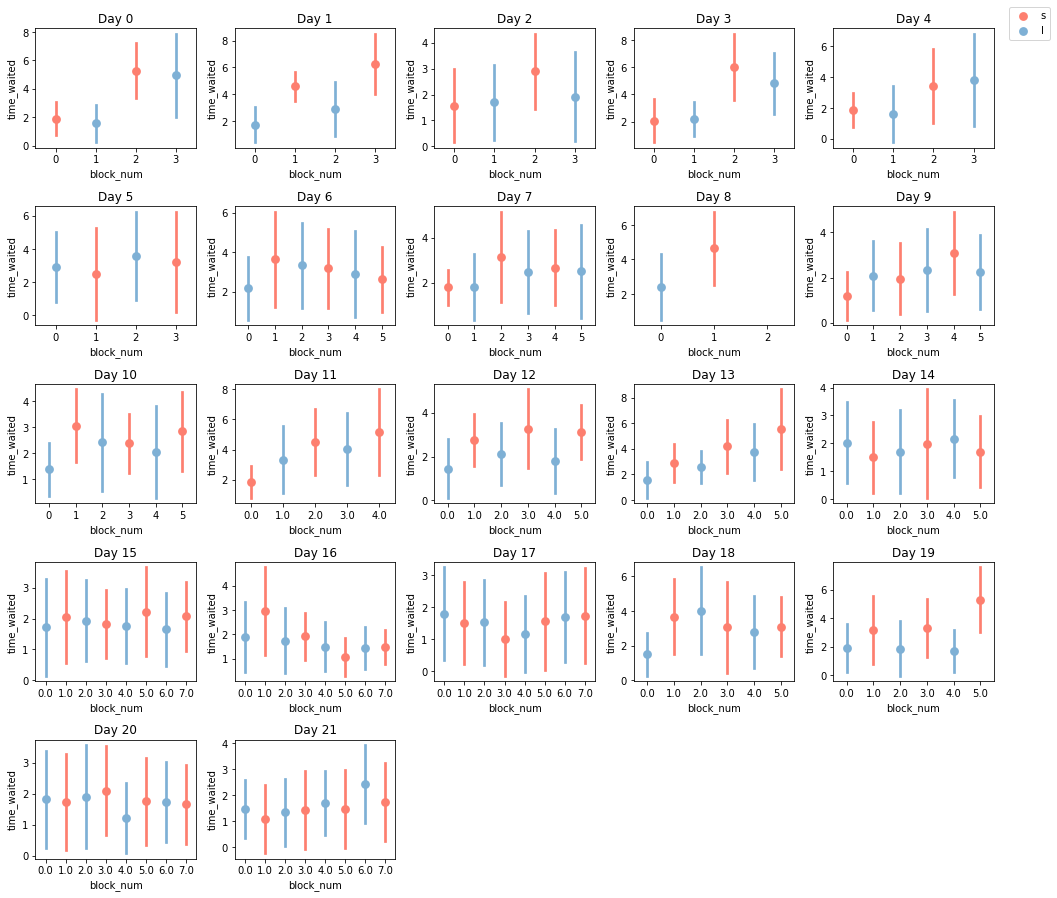

In [33]:
for mouse in mouse_list:
    session_mouse = training_session_log.loc[training_session_log.mouse == mouse]
    days_trained = len(session_mouse)

    # Calculate the number of rows and columns for the subplot grid
    num_rows = (days_trained - 1) // 5 + 1
    num_cols = min(days_trained, 5)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(14, 2.5 * num_rows))

    for i, (dir_name, day) in enumerate(zip(session_mouse.dir, session_mouse.days)):
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        row_idx = i // num_cols
        col_idx = i % num_cols
        ax = axs[row_idx, col_idx]

        sns.pointplot(x="block_num",
                        y="time_waited",
                        errorbar='sd',
                        hue="blk_type",
                        data=all_trials,
                        palette=custom_palette,
                        ax=axs.flat[i])
        ax.set_title(f'Day {day}')

    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1))
    
    # Remove any unused subplots
    if i + 1 < num_rows * num_cols:
        for j in range(i + 1, num_rows * num_cols):
            axs.flat[j].axis('off')
    
    for i in range(days_trained):
        ax = axs.flat[i]
        ax.get_legend().remove()

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Save the figure with proper spacing around the subplots
    plt.savefig(f'{figure_folder}/trial_num_vs_tw_pointplot_{mouse}.png', bbox_inches='tight', dpi=300)

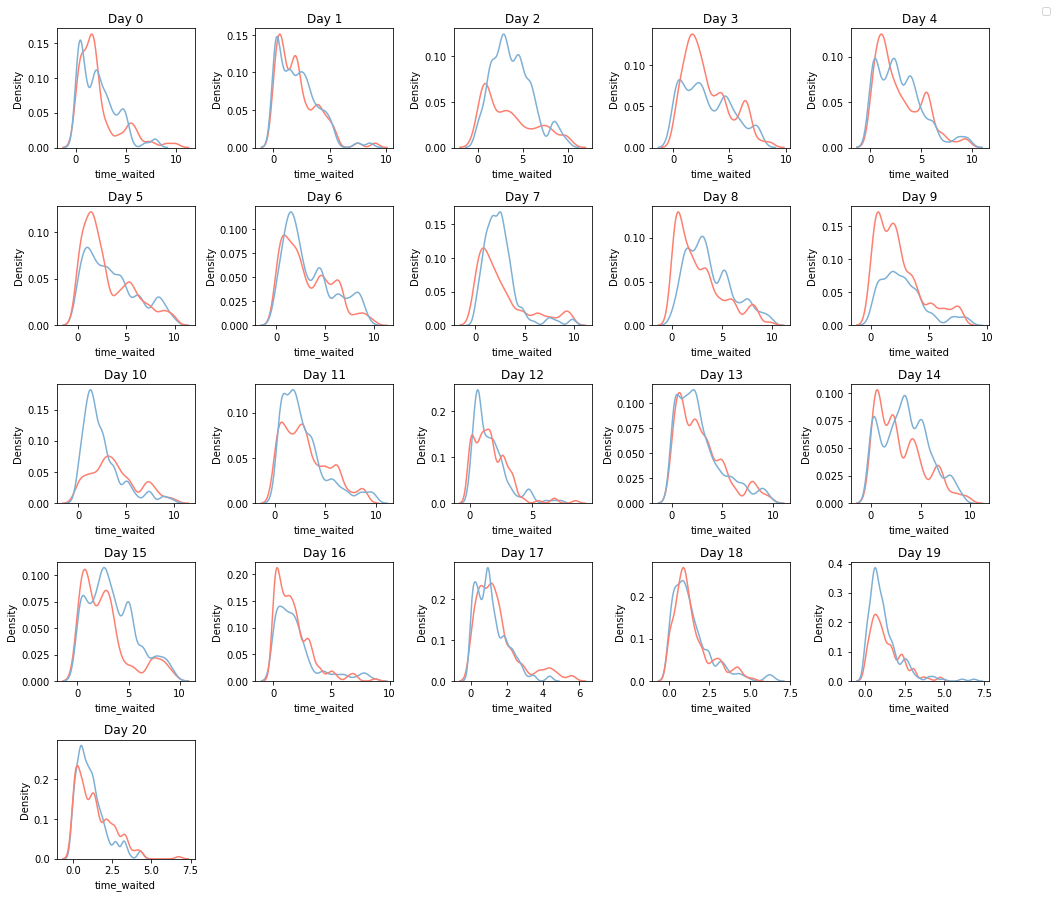

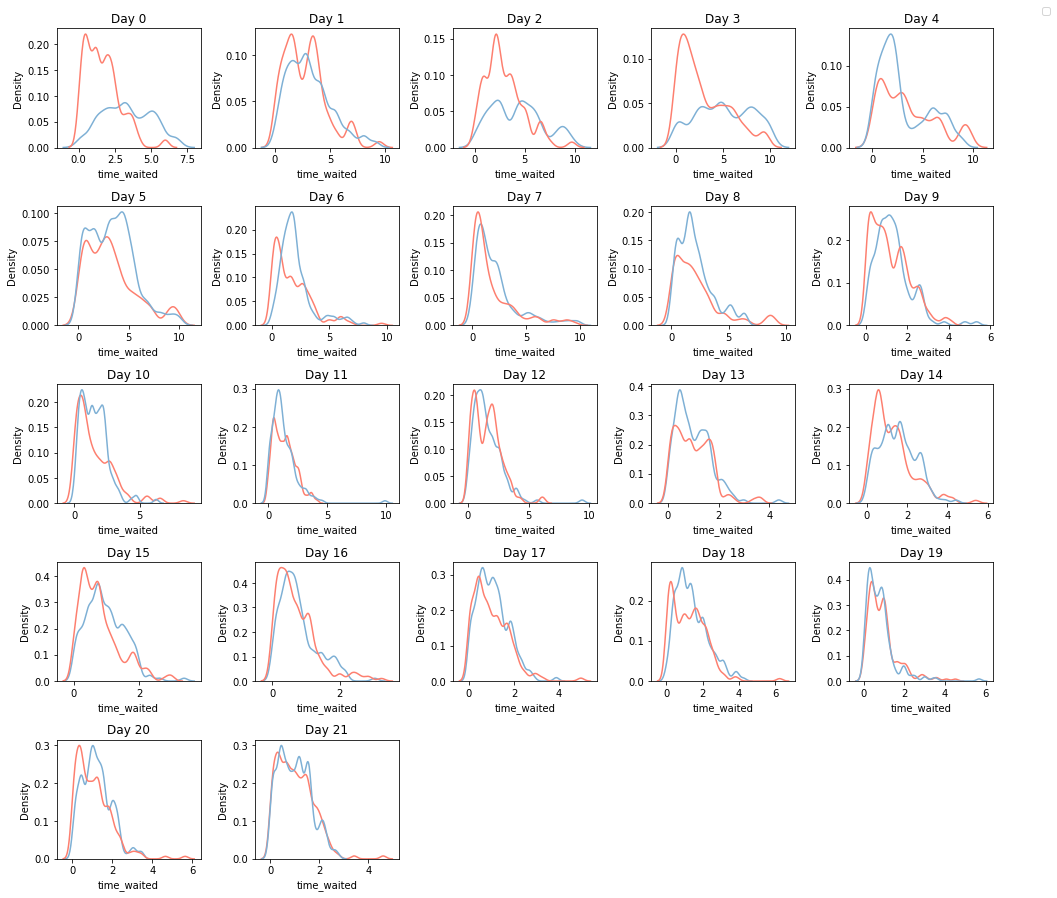

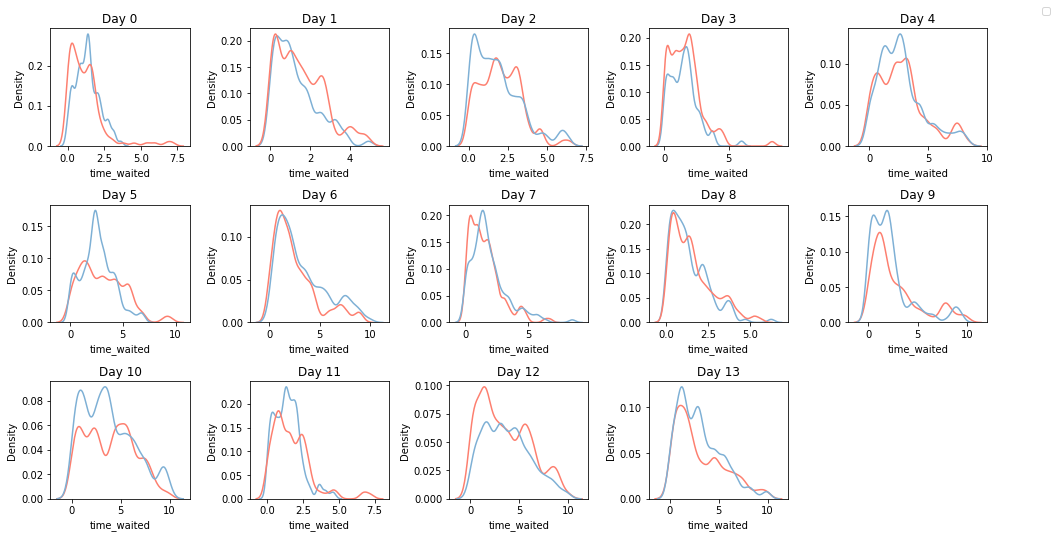

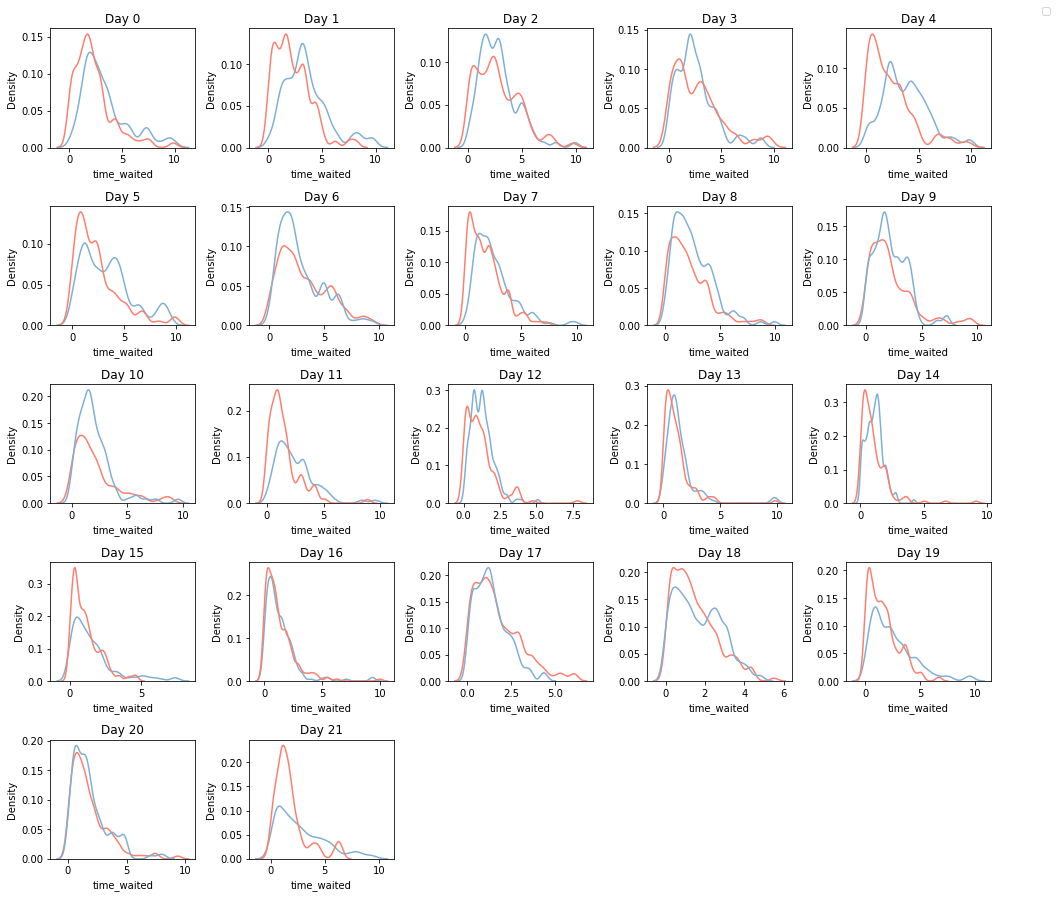

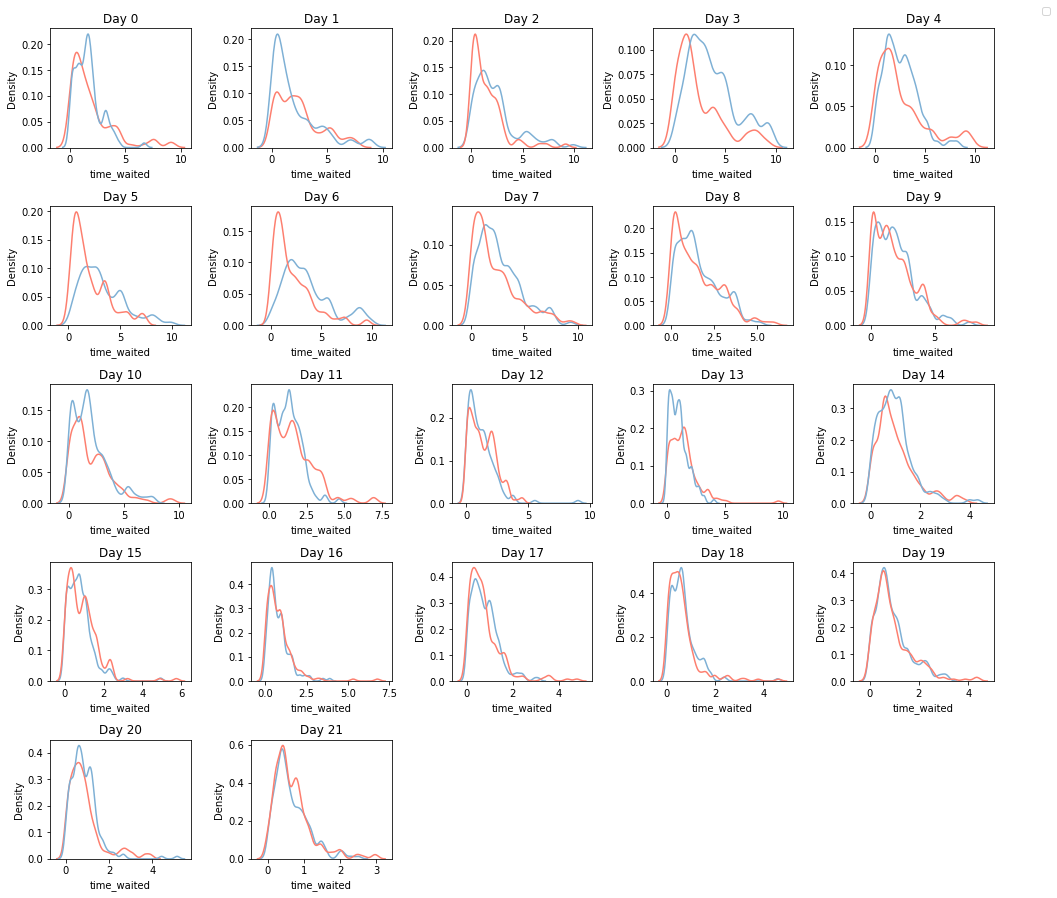

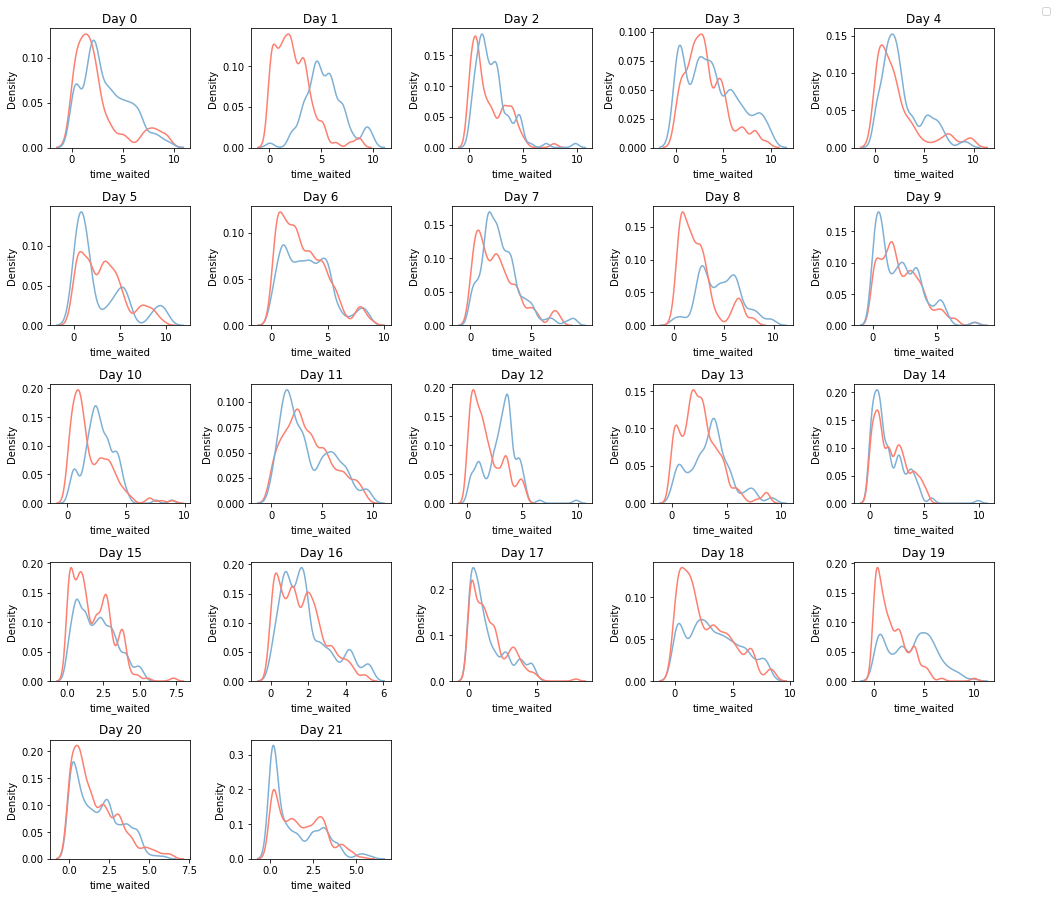

In [124]:
for mouse in mouse_list:
    session_mouse = training_session_log.loc[training_session_log.mouse == mouse]
    days_trained = len(session_mouse)

    # Calculate the number of rows and columns for the subplot grid
    num_rows = (days_trained - 1) // 5 + 1
    num_cols = min(days_trained, 5)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(14, 2.5 * num_rows))

    for i, (dir_name, day) in enumerate(zip(session_mouse.dir, session_mouse.days)):
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        row_idx = i // num_cols
        col_idx = i % num_cols
        ax = axs[row_idx, col_idx]

        sns.kdeplot(data=all_trials, 
                    x="time_waited", 
                    hue="blk_type",
                    bw_adjust=0.5, 
                    palette=custom_palette,
                    ax=axs.flat[i])
    
        ax.set_title(f'Day {day}')

    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1))
    
    # Remove any unused subplots
    if i + 1 < num_rows * num_cols:
        for j in range(i + 1, num_rows * num_cols):
            axs.flat[j].axis('off')
    
    for i in range(days_trained):
        ax = axs.flat[i]
        ax.get_legend().remove()

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Save the figure with proper spacing around the subplots
    plt.savefig(f'{figure_folder}/tw_kde_{mouse}.png', bbox_inches='tight', dpi=300)

# Some stats

In [126]:
import scipy.stats as s_stats

In [129]:
mouse_list

['RZ012', 'RZ013', 'RZ014', 'RZ015', 'RZ016', 'RZ017']

### Check if boys and girls are significantly different

In [1]:
boys =  ['RZ015', 'RZ016', 'RZ017']
girls = ['RZ012', 'RZ013', 'RZ014']

boy = wait_df['tw_mean'][wait_df['mouse'].isin(boys)]
girl = wait_df['tw_mean'][wait_df['mouse'].isin(girls)]

b_vs_g = s_stats.ttest_ind(boy, girl)

b_vs_g

NameError: name 'wait_df' is not defined

In [131]:
s_stats.f_oneway(wait_df['tw_mean'][wait_df['mouse'] == 'RZ015'],
                 wait_df['tw_mean'][wait_df['mouse'] == 'RZ016'],
                 wait_df['tw_mean'][wait_df['mouse'] == 'RZ017'],
                 wait_df['tw_mean'][wait_df['mouse'] == 'RZ012'],
                 wait_df['tw_mean'][wait_df['mouse'] == 'RZ013'],
                 wait_df['tw_mean'][wait_df['mouse'] == 'RZ014'])

F_onewayResult(statistic=4.7139839762961495, pvalue=0.000585922431299455)